In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# === Step 1. Load both datasets ===
preds = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx')
imbalance_raw = pd.read_excel(
  '/content/drive/MyDrive/Colab Notebooks/Sunly test/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx',
    sheet_name="Worksheet",
    skiprows=2  # skip the header rows
)

# === Step 2. Extract and clean Estonia columns ===
imbalance_estonia = imbalance_raw.iloc[:, [0, 1, 2, 3]]  # From, To, Upward, Downward
imbalance_estonia.columns = ["start_time", "end_time", "upward_price", "downward_price"]

# Convert times to datetime
imbalance_estonia["start_time"] = pd.to_datetime(imbalance_estonia["start_time"], errors="coerce")
imbalance_estonia["end_time"] = pd.to_datetime(imbalance_estonia["end_time"], errors="coerce")

# Drop rows without valid timestamps
imbalance_estonia = imbalance_estonia.dropna(subset=["start_time"])

# === Step 3. Clean the Predictions dataset ===
preds = preds.rename(columns={"start_time": "start_time"})
preds["start_time"] = pd.to_datetime(preds["start_time"], errors="coerce")

# === Step 4. Merge ===
merged = pd.merge(preds, imbalance_estonia, on="start_time", how="left")

# === Step 5. Check coverage ===
coverage = merged["upward_price"].notna().mean() * 100
print(f"Matched imbalance prices for {coverage:.1f}% of MTUs")

# === Step 6. Preview result ===
print(merged.head(5))

# === Step 7. Save merged dataset ===
merged.to_excel("merged_predictions_with_imbalance.xlsx", index=False)
print("✅ Merged dataset saved as merged_predictions_with_imbalance.xlsx")


/tmp/ipython-input-4011024355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imbalance_estonia["start_time"] = pd.to_datetime(imbalance_estonia["start_time"], errors="coerce")
/tmp/ipython-input-4011024355.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imbalance_estonia["end_time"] = pd.to_datetime(imbalance_estonia["end_time"], errors="coerce")


Matched imbalance prices for 99.9% of MTUs
           start_time unit  pv_power_prediction_day_ahead_p10  \
0 2025-09-15 00:15:00   kW                                  0   
1 2025-09-15 00:30:00   kW                                  0   
2 2025-09-15 00:45:00   kW                                  0   
3 2025-09-15 01:00:00   kW                                  0   
4 2025-09-15 01:15:00   kW                                  0   

   pv_power_prediction_day_ahead_p50  pv_power_prediction_day_ahead_p90  \
0                                0.0                                  0   
1                                0.0                                  0   
2                                0.0                                  0   
3                                0.0                                  0   
4                                0.0                                  0   

   actual_power  Unnamed: 6   unit.1  day-ahead price            end_time  \
0           0.0         NaN  EUR/MWh  

# Potential submission

In [ ]:
"""
Full pipeline: Monte-Carlo + CVaR + (optionally stochastic) imbalance + P-level mapping
Assumes:
 - Predictions.xlsx present at /mnt/data/Predictions.xlsx (Sheet1)
 - Imbalance Excel present at /mnt/data/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx
Outputs:
 - /mnt/data/da_strategy_results.xlsx (per-MTU results and summary)
"""

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import math

# ---------------------------
# CONFIGURATION (tweakable)
# ---------------------------
PREDICTIONS_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'
PREDICTIONS_SHEET = "Sheet1"

IMBALANCE_PATH =  '/content/drive/MyDrive/Colab Notebooks/Sunly test/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx'
IMBALANCE_SHEET = "Worksheet"  # as in uploaded file

OUTPUT_XLSX = "merged_predictions_with_imbalance.xlsx"

# Monte Carlo
NUM_SIMS = 3000               # sims per MTU (2k-5k typical)
RNG_SEED = 2025
np.random.seed(RNG_SEED)

# CVaR
CVaR_ALPHA = 0.05             # 5% tail for CVaR calculations
CVaR_LIMIT = None             # set e.g. -200 to enforce CVaR >= -200 EUR (per-MTU). None disables constraint.

# Curtailment
CURTAIL_ALLOWED = True
CURTAIL_COST_PER_MWH = 0.0    # set >0 if you want to penalize curtailment

# Unit conversion kW -> MWh per 15-min MTU
KW_TO_MWH = 0.25 / 1000.0

# Use real imbalance prices from file if present; if True, per-sim up/down arrays take that MTU value
USE_REAL_IMBALANCE = True

# If using real imbalance prices, you can optionally add stochastic perturbations + rare spikes for stress-test:
ADD_IMBALANCE_NOISE = False    # if True, adds a random spread around baseline
IMBALANCE_NOISE_PARAMS = {
    "sigma_up": 10.0,          # std dev around baseline upward (€/MWh)
    "sigma_down": 7.0,
    "spike_prob": 0.007,       # rare spike prob per sim
    "spike_up_min": 150.0,
    "spike_up_max": 800.0
}

# If no real imbalance prices available for some MTUs, fallback spreads:
FALLBACK_UP_SPREAD = 30.0      # €/MWh above DA_price
FALLBACK_DOWN_SPREAD = 20.0    # €/MWh below DA_price

# Candidate grid resolution (continuous sold volume search)
CANDIDATE_STEPS = 51

# ---------------------------
# Helper: load & clean predictions
# ---------------------------
def load_predictions(path=PREDICTIONS_PATH, sheet=PREDICTIONS_SHEET):
    df = pd.read_excel(path, sheet_name=sheet)
    # Drop metadata columns if present
    df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")
    df = df.rename(columns={
        "pv_power_prediction_day_ahead_p10": "P10_kW",
        "pv_power_prediction_day_ahead_p50": "P50_kW",
        "pv_power_prediction_day_ahead_p90": "P90_kW",
        "actual_power": "Actual_kW",
        "day-ahead price": "DA_price"
    })
    # Ensure datetime
    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time").reset_index(drop=True)
    # Add MWh columns
    df["P10_MWh"] = df["P10_kW"] * KW_TO_MWH
    df["P50_MWh"] = df["P50_kW"] * KW_TO_MWH
    df["P90_MWh"] = df["P90_kW"] * KW_TO_MWH
    df["Actual_MWh"] = df["Actual_kW"] * KW_TO_MWH
    return df

# ---------------------------
# Helper: load & parse imbalance prices (Estonia)
# ---------------------------
def load_imbalance_prices(path=IMBALANCE_PATH, sheet=IMBALANCE_SHEET):
    # The uploaded sheet had two header rows; skip first two rows as earlier inspection
    raw = pd.read_excel(path, sheet_name=sheet, header=None)
    # Determine how to parse: expected format with first two rows header:
    # Row0: [ "Balancing energy reference prices", NaN, "Estonia", NaN, "Latvia", ... ]
    # Row1: [ "From", "To", "Upward", "Downward", "Upward", ... ]
    # We want columns for Estonia: From, To, Upward, Downward (likely columns 0..3)
    # We'll attempt to find the columns by scanning row1 values.

    # Convert first few rows to strings to inspect
    # We'll assume the first data row with timestamps is row index 2 (0-based), as in earlier preview.
    # Build dataframe from row 2 onward, and map columns 0..3 to Estonia.
    data = pd.read_excel(path, sheet_name=sheet, header=2)  # header at row index 2 to read column names from row2 (not ideal)
    # But above may produce columns named 'From', 'To', 'Upward', 'Downward', 'Upward.1', ...
    # We'll try to pick Estonia columns by position: first group of From/To/Up/Down.
    # Find columns whose names contain 'From' or 'To' to determine leftmost block
    cols = list(data.columns)
    # Strategy: try to detect "From" column index
    from_idx = None
    for i, c in enumerate(cols):
        if isinstance(c, str) and c.strip().lower() in ["from", "from " , "from.1", "from.2"]:
            from_idx = i
            break
    # Fallback: assume first column is start time
    if from_idx is None:
        from_idx = 0
    # We will take columns [from_idx, from_idx+1, from_idx+2, from_idx+3] as Estonia block
    est_cols = cols[from_idx: from_idx+4]
    # Rename them to standard names
    # Ensure we have at least 4 cols
    if len(est_cols) < 4:
        raise ValueError("Unexpected imbalance sheet layout - couldn't detect Estonia block.")
    est_df = data[est_cols].copy()
    est_df.columns = ["start_time", "end_time", "upward_price", "downward_price"]
    # Parse datetimes robustly
    est_df["start_time"] = pd.to_datetime(est_df["start_time"], errors="coerce")
    est_df["end_time"] = pd.to_datetime(est_df["end_time"], errors="coerce")
    # Drop rows where start_time is NaT
    est_df = est_df.dropna(subset=["start_time"]).reset_index(drop=True)
    # Convert price columns to numeric
    est_df["upward_price"] = pd.to_numeric(est_df["upward_price"], errors="coerce")
    est_df["downward_price"] = pd.to_numeric(est_df["downward_price"], errors="coerce")
    return est_df

# ---------------------------
# Sampling functions
# ---------------------------
def sample_production_triangular(p10, p50, p90, n=NUM_SIMS):
    # if p90 <= p10, return constant array at p10
    a, c, b = float(p10), float(p50), float(p90)
    if b <= a + 1e-12:
        return np.full(n, a)
    return np.random.triangular(left=a, mode=c, right=b, size=n)

def sample_imbalance_prices_baseline(da_price, up_baseline, down_baseline, n=NUM_SIMS,
                                     add_noise=False, noise_params=IMBALANCE_NOISE_PARAMS):
    """
    If real imbalance baseline is available, create per-sim arrays:
    - by default, repeat baseline value across sims
    - if add_noise True, add Normal noise around baseline and occasional spikes
    """
    if not add_noise:
        up_arr = np.full(n, float(up_baseline))
        down_arr = np.full(n, float(down_baseline))
        return up_arr, down_arr, np.zeros(n, dtype=bool)
    # else add noise
    sigma_up = noise_params.get("sigma_up", 10.0)
    sigma_down = noise_params.get("sigma_down", 7.0)
    p_spike = noise_params.get("spike_prob", 0.007)
    spike_min = noise_params.get("spike_up_min", 150.0)
    spike_max = noise_params.get("spike_up_max", 800.0)
    up_noise = np.random.normal(loc=0.0, scale=sigma_up, size=n)
    down_noise = np.random.normal(loc=0.0, scale=sigma_down, size=n)
    up_arr = np.maximum(0.0, up_baseline + up_noise)
    down_arr = np.maximum(0.0, down_baseline + down_noise)
    # spikes
    spike_flags = np.random.rand(n) < p_spike
    if spike_flags.any():
        spikes = np.random.uniform(low=spike_min, high=spike_max, size=spike_flags.sum())
        up_arr[spike_flags] = spikes
    return up_arr, down_arr, spike_flags

def sample_imbalance_prices_fallback(da_price, n=NUM_SIMS, fallback_up=FALLBACK_UP_SPREAD, fallback_down=FALLBACK_DOWN_SPREAD):
    # Use DA price ± fallback spreads
    up_arr = np.full(n, da_price + fallback_up)
    down_arr = np.full(n, max(0.0, da_price - fallback_down))  # ensure non-negative downward baseline
    return up_arr, down_arr, np.zeros(n, dtype=bool)

# ---------------------------
# Revenue evaluation & CVaR
# ---------------------------
def evaluate_revenue_per_sim(sold_mwh, actual_samples, da_price, up_prices, down_prices, curtail_allowed=CURTAIL_ALLOWED, curtail_cost_per_mwh=CURTAIL_COST_PER_MWH):
    """Return array of per-sim total revenue in EUR for fixed sold_mwh (scalar)."""
    da_rev = sold_mwh * da_price  # scalar
    if curtail_allowed:
        actual_after = np.minimum(actual_samples, sold_mwh)
        curtail_vol = np.maximum(0.0, actual_samples - sold_mwh)
    else:
        actual_after = actual_samples
        curtail_vol = np.zeros_like(actual_samples)
    imbalance = actual_after - sold_mwh  # negative => short (we pay upward)
    # select price elementwise
    imbal_price = np.where(imbalance < 0, up_prices, down_prices)
    imbal_rev = imbalance * imbal_price
    curtail_costs = -(curtail_vol * curtail_cost_per_mwh)
    total_rev = da_rev + imbal_rev + curtail_costs
    return total_rev

def compute_expected_and_cvar(total_rev_array, alpha=CVaR_ALPHA):
    exp = float(np.mean(total_rev_array))
    # CVaR: mean of worst alpha fraction
    q = np.quantile(total_rev_array, alpha)
    tail = total_rev_array[total_rev_array <= q]
    cvar = float(tail.mean()) if tail.size > 0 else float(q)
    return exp, cvar

# ---------------------------
# Per-MTU optimization
# ---------------------------
def optimize_mtu_candidates(p10_mwh, p50_mwh, p90_mwh, da_price, up_baseline, down_baseline):
    """
    For a single MTU:
      - sample production (triangular)
      - create per-sim up/down arrays (either from baseline or fallback)
      - evaluate candidate grid of sold volumes (0 .. max(P90, mean*1.25))
      - choose best continuous sold_mwh by expected revenue subject to CVaR_LIMIT (if set)
      - also evaluate P10/P50/P90 under same draws and pick best P-level
    Returns dict of results for that MTU.
    """
    # Simulate actual production
    actual_samples = sample_production_triangular(p10_mwh, p50_mwh, p90_mwh, n=NUM_SIMS)

    # Build imbalance price samples:
    if up_baseline is not None and down_baseline is not None:
        up_arr, down_arr, spike_flags = sample_imbalance_prices_baseline(
            da_price=da_price, up_baseline=up_baseline, down_baseline=down_baseline,
            n=NUM_SIMS, add_noise=ADD_IMBALANCE_NOISE, noise_params=IMBALANCE_NOISE_PARAMS)
    else:
        up_arr, down_arr, spike_flags = sample_imbalance_prices_fallback(da_price, n=NUM_SIMS)

    # Candidate grid
    max_cand = max(p90_mwh, actual_samples.mean()*1.25, 1e-6)
    cand_grid = np.linspace(0.0, max_cand, CANDIDATE_STEPS)

    best = {"sold_mwh": 0.0, "exp_rev": -1e18, "cvar": None, "cand_grid": cand_grid}
    for s in cand_grid:
        tr = evaluate_revenue_per_sim(s, actual_samples, da_price, up_arr, down_arr)
        exp, cvar = compute_expected_and_cvar(tr, alpha=CVaR_ALPHA)
        if (CVaR_LIMIT is not None) and (cvar < CVaR_LIMIT):
            continue
        if exp > best["exp_rev"]:
            best.update({"sold_mwh": float(s), "exp_rev": exp, "cvar": cvar})

    # Evaluate P-levels using same simulations
    p_levels = {"P10": p10_mwh, "P50": p50_mwh, "P90": p90_mwh}
    p_results = {}
    for k, sold in p_levels.items():
        tr = evaluate_revenue_per_sim(sold, actual_samples, da_price, up_arr, down_arr)
        exp, cvar = compute_expected_and_cvar(tr, alpha=CVaR_ALPHA)
        p_results[k] = {"sold_mwh": float(sold), "exp_rev": exp, "cvar": cvar}

    # Choose best p-level by expected revenue subject to CVaR constraint
    best_p = None
    for k, v in p_results.items():
        if (CVaR_LIMIT is not None) and (v["cvar"] < CVaR_LIMIT):
            continue
        if best_p is None or v["exp_rev"] > best_p["exp_rev"]:
            best_p = {"level": k, **v}

    return {
        "best_cont_sold_mwh": best["sold_mwh"],
        "best_cont_exp_rev": best["exp_rev"],
        "best_cont_cvar": best["cvar"],
        "p_results": p_results,
        "best_p": best_p,
        "sim_mean_actual": float(actual_samples.mean()),
        "sim_std_actual": float(actual_samples.std()),
        "spike_count": int(spike_flags.sum())
    }

# ---------------------------
# Pipeline: merge and run optimization across MTUs
# ---------------------------
def run_full_pipeline():
    preds = load_predictions(PREDICTIONS_PATH, PREDICTIONS_SHEET)
    imb = load_imbalance_prices(IMBALANCE_PATH, IMBALANCE_SHEET)

    # merge on start_time
    merged = pd.merge(preds, imb[["start_time", "upward_price", "downward_price"]], on="start_time", how="left")
    # Report coverage
    matched_pct = 100.0 * merged["upward_price"].notna().mean()
    print(f"Matched imbalance prices for {matched_pct:.1f}% of MTUs (Estonia)")

    # For rows without imbalance prices, we'll use fallback spreads (from DA price)
    merged["upward_price_filled"] = merged["upward_price"]
    merged["downward_price_filled"] = merged["downward_price"]
    mask_missing = merged["upward_price_filled"].isna() | merged["downward_price_filled"].isna()
    if mask_missing.any():
        print(f"Filling {mask_missing.sum()} missing MTUs with fallback spreads relative to DA price.")
        merged.loc[mask_missing, "upward_price_filled"] = merged.loc[mask_missing, "DA_price"] + FALLBACK_UP_SPREAD
        merged.loc[mask_missing, "downward_price_filled"] = merged.loc[mask_missing, "DA_price"] - FALLBACK_DOWN_SPREAD

    # Run per-MTU optimization
    results = []
    print("Running per-MTU Monte-Carlo optimizations...")
    for i, row in tqdm(merged.iterrows(), total=len(merged), desc="MTUs"):
        p10 = row["P10_MWh"]; p50 = row["P50_MWh"]; p90 = row["P90_MWh"]
        da_p = float(row["DA_price"])
        up_base = float(row["upward_price_filled"]) if not math.isnan(row["upward_price_filled"]) else None
        down_base = float(row["downward_price_filled"]) if not math.isnan(row["downward_price_filled"]) else None

        res = optimize_mtu_candidates(p10, p50, p90, da_p, up_base, down_base)
        results.append({
            "start_time": row["start_time"],
            "P10_MWh": p10, "P50_MWh": p50, "P90_MWh": p90,
            "Actual_MWh_obs": row["Actual_MWh"],
            "DA_price": da_p,
            "Upward_price_used": up_base, "Downward_price_used": down_base,
            "best_cont_sold_mwh": res["best_cont_sold_mwh"],
            "best_cont_exp_rev": res["best_cont_exp_rev"],
            "best_cont_cvar": res["best_cont_cvar"],
            "best_p_level": (res["best_p"]["level"] if res["best_p"] is not None else None),
            "best_p_sold_mwh": (res["best_p"]["sold_mwh"] if res["best_p"] is not None else None),
            "best_p_exp_rev": (res["best_p"]["exp_rev"] if res["best_p"] is not None else None),
            "best_p_cvar": (res["best_p"]["cvar"] if res["best_p"] is not None else None),
            "sim_mean_actual": res["sim_mean_actual"],
            "sim_std_actual": res["sim_std_actual"],
            "sim_spike_count": res["spike_count"]
        })

    results_df = pd.DataFrame(results)
    # Summaries
    total_expected_cont = results_df["best_cont_exp_rev"].sum()
    total_expected_best_p = results_df["best_p_exp_rev"].sum()
    print(f"Total expected revenue (continuous opt): {total_expected_cont:.2f} EUR")
    print(f"Total expected revenue (best P-level):   {total_expected_best_p:.2f} EUR")

    # Compute realized revenue using observed actuals and used upward/downward prices (deterministic realized calculation)
    def realized_row(row, sold_mwh_col):
        sold = float(row[sold_mwh_col])
        da = float(row["DA_price"])
        up_price = float(row["Upward_price_used"])
        down_price = float(row["Downward_price_used"])
        actual = float(row["Actual_MWh_obs"])
        if CURTAIL_ALLOWED:
            actual_after = min(actual, sold)
            curtail_vol = max(0.0, actual - sold)
        else:
            actual_after = actual
            curtail_vol = 0.0
        imbalance = actual_after - sold
        imbal_rev = imbalance * (up_price if imbalance < 0 else down_price)
        curtail_costs = -(curtail_vol * CURTAIL_COST_PER_MWH)
        return sold * da + imbal_rev + curtail_costs

    # Add realized columns
    results_df["realized_rev_cont_assumed_imp"] = results_df.apply(lambda r: realized_row(r, "best_cont_sold_mwh"), axis=1)
    results_df["realized_rev_best_p_assumed_imp"] = results_df.apply(lambda r: realized_row(r, "best_p_sold_mwh"), axis=1)

    # Save Excel
    with pd.ExcelWriter(OUTPUT_XLSX) as w:
        merged.to_excel(w, sheet_name="merged_input", index=False)
        results_df.to_excel(w, sheet_name="mtu_results", index=False)
        summary = {
            "total_expected_continuous": total_expected_cont,
            "total_expected_best_p": total_expected_best_p,
            "n_mtu": len(results_df)
        }
        pd.DataFrame([summary]).to_excel(w, sheet_name="summary", index=False)

    print("Saved results to:", OUTPUT_XLSX)
    return merged, results_df

# ---------------------------
# Execute
# ---------------------------
if __name__ == "__main__":
    merged_input, results = run_full_pipeline()


Matched imbalance prices for 99.9% of MTUs (Estonia)
Filling 1 missing MTUs with fallback spreads relative to DA price.
Running per-MTU Monte-Carlo optimizations...


MTUs: 100%|██████████| 1535/1535 [00:21<00:00, 72.72it/s]


Total expected revenue (continuous opt): 211378.57 EUR
Total expected revenue (best P-level):   199475.85 EUR
Saved results to: merged_predictions_with_imbalance.xlsx


Loaded 1535 MTUs covering 16 days.

=== KEY KPIs ===
Total Expected Continuous (EUR): 211,378.57
Total Expected Best P-level (EUR): 199,475.85
Mean CVaR Continuous (EUR): 137.71
Mean CVaR Best P-level (EUR): 129.95
Mean Continuous Sold MWh: 2.49
Mean Best P-level Sold MWh: 2.35

P-level selection frequency (%):
best_p_level
P10    98.96
P90     1.04
Name: proportion, dtype: float64


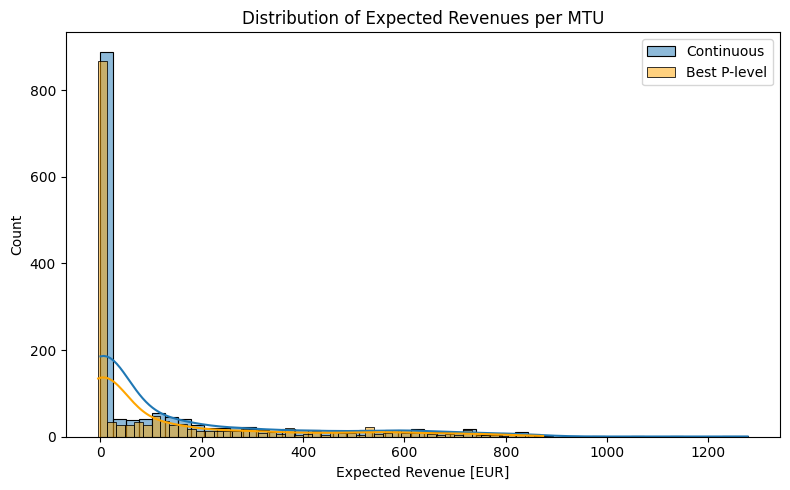

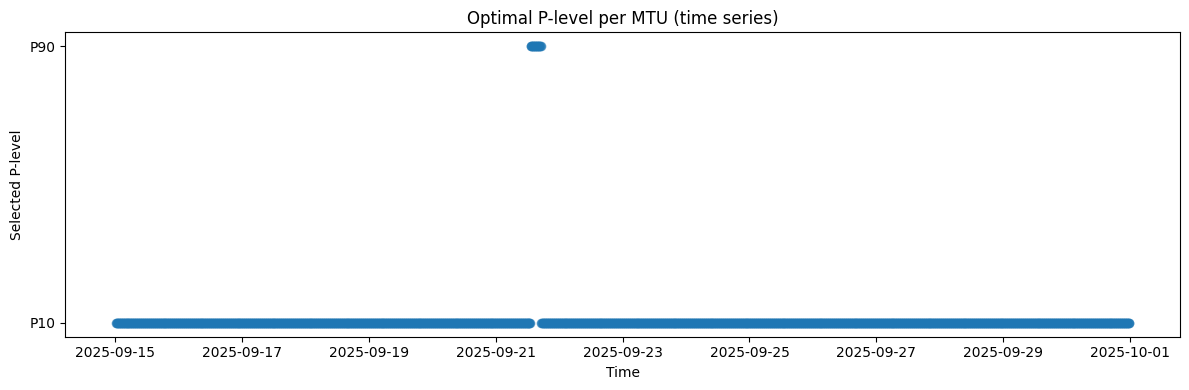

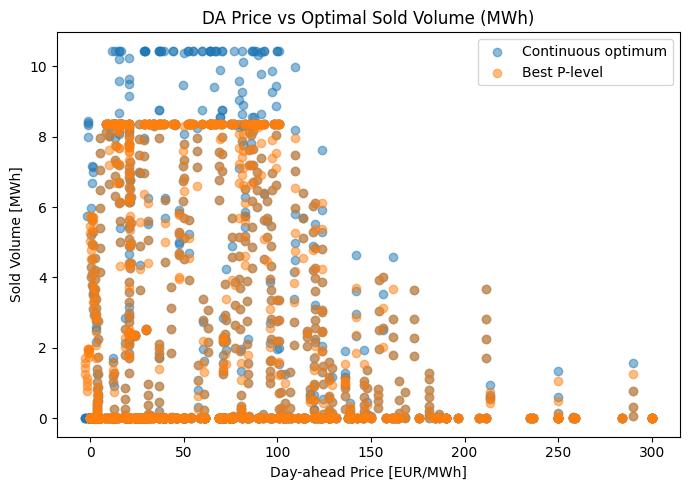

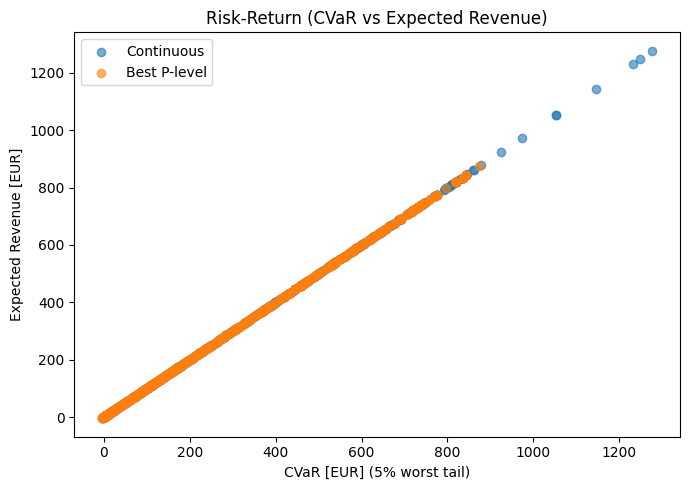

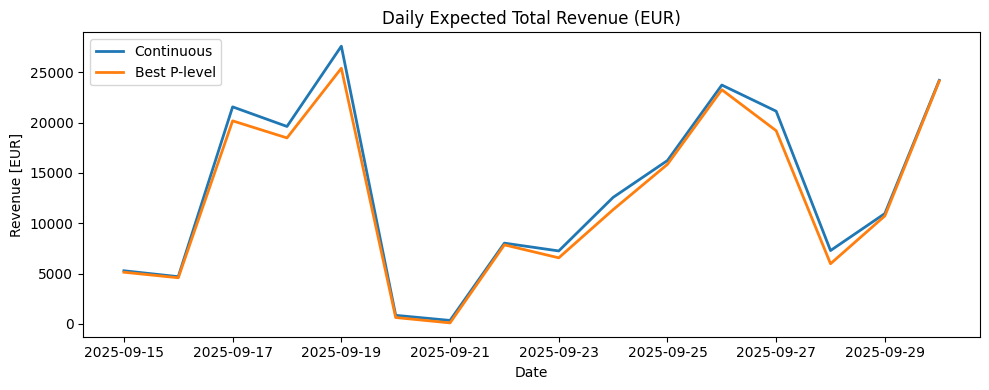


=== PERFORMANCE IMPROVEMENT ===
   Total Expected Continuous (EUR)  Total Expected Best P-level (EUR)  \
0                    211378.566793                      199475.847968   

   Improvement (Continuous vs P-level) %  
0                               5.966997  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
RESULTS_PATH = "merged_predictions_with_imbalance.xlsx"

# --- Load data ---
results = pd.read_excel(RESULTS_PATH, sheet_name="mtu_results")
summary = pd.read_excel(RESULTS_PATH, sheet_name="summary")

# Convert datetime
results["start_time"] = pd.to_datetime(results["start_time"])
results["date"] = results["start_time"].dt.date

print("Loaded", len(results), "MTUs covering", results["date"].nunique(), "days.")

# --- KPI Calculations ---
kpis = {
    "Total Expected Continuous (EUR)": results["best_cont_exp_rev"].sum(),
    "Total Expected Best P-level (EUR)": results["best_p_exp_rev"].sum(),
    "Mean CVaR Continuous (EUR)": results["best_cont_cvar"].mean(),
    "Mean CVaR Best P-level (EUR)": results["best_p_cvar"].mean(),
    "Mean Continuous Sold MWh": results["best_cont_sold_mwh"].mean(),
    "Mean Best P-level Sold MWh": results["best_p_sold_mwh"].mean(),
}

print("\n=== KEY KPIs ===")
for k, v in kpis.items():
    print(f"{k}: {v:,.2f}")

# --- Compare P-level frequencies ---
p_level_counts = results["best_p_level"].value_counts(normalize=True) * 100
print("\nP-level selection frequency (%):")
print(p_level_counts.round(2))

# --- 1️⃣ Plot: Distribution of expected revenues ---
plt.figure(figsize=(8,5))
sns.histplot(results["best_cont_exp_rev"], bins=50, label="Continuous", kde=True)
sns.histplot(results["best_p_exp_rev"], bins=50, label="Best P-level", kde=True, color='orange')
plt.title("Distribution of Expected Revenues per MTU")
plt.xlabel("Expected Revenue [EUR]")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2️⃣ Plot: Time series of P-level selection ---
plt.figure(figsize=(12,4))
plt.scatter(results["start_time"], results["best_p_level"], c="tab:blue", alpha=0.6)
plt.title("Optimal P-level per MTU (time series)")
plt.xlabel("Time")
plt.ylabel("Selected P-level")
plt.tight_layout()
plt.show()

# --- 3️⃣ Scatter: DA price vs optimal sold volume ---
plt.figure(figsize=(7,5))
plt.scatter(results["DA_price"], results["best_cont_sold_mwh"], alpha=0.5, label="Continuous optimum")
plt.scatter(results["DA_price"], results["best_p_sold_mwh"], alpha=0.5, label="Best P-level")
plt.title("DA Price vs Optimal Sold Volume (MWh)")
plt.xlabel("Day-ahead Price [EUR/MWh]")
plt.ylabel("Sold Volume [MWh]")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4️⃣ Risk-Return frontier (CVaR vs Expected Rev) ---
plt.figure(figsize=(7,5))
plt.scatter(results["best_cont_cvar"], results["best_cont_exp_rev"], label="Continuous", alpha=0.6)
plt.scatter(results["best_p_cvar"], results["best_p_exp_rev"], label="Best P-level", alpha=0.6)
plt.title("Risk-Return (CVaR vs Expected Revenue)")
plt.xlabel("CVaR [EUR] (5% worst tail)")
plt.ylabel("Expected Revenue [EUR]")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5️⃣ Aggregate daily expected revenues ---
daily = results.groupby("date")[["best_cont_exp_rev","best_p_exp_rev"]].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["best_cont_exp_rev"], label="Continuous", lw=2)
plt.plot(daily["date"], daily["best_p_exp_rev"], label="Best P-level", lw=2)
plt.title("Daily Expected Total Revenue (EUR)")
plt.xlabel("Date")
plt.ylabel("Revenue [EUR]")
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: KPI summary table ---
kpi_table = pd.DataFrame([kpis])
kpi_table["Improvement (Continuous vs P-level) %"] = (
    (kpi_table["Total Expected Continuous (EUR)"] / kpi_table["Total Expected Best P-level (EUR)"] - 1) * 100
)
print("\n=== PERFORMANCE IMPROVEMENT ===")
print(kpi_table[["Total Expected Continuous (EUR)", "Total Expected Best P-level (EUR)", "Improvement (Continuous vs P-level) %"]])


# Second solution, for possiblem improvements

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# =========================== #
# CONFIGURATION
# =========================== #
PREDICTIONS_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'
PREDICTIONS_SHEET = "Sheet1"

IMBALANCE_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx'
IMBALANCE_SHEET = "Worksheet"

OUTPUT_XLSX = "merged_predictions_with_quantile_strategy.xlsx"

NUM_SIMS = 3000
RNG_SEED = 2025
np.random.seed(RNG_SEED)

KW_TO_MWH = 0.25 / 1000.0  # 15 min interval in MWh
CURTAIL_ALLOWED = True
CURTAIL_COST_PER_MWH = 0.0

QUANTILE_LEVEL = 0.10  # lower quantile for more conservative strategy
USE_CVaR = True        # set False to use quantile instead

CVaR_ALPHA = 0.05

# Noise for imbalance simulation
ADD_IMBALANCE_NOISE = True
IMBALANCE_NOISE_PARAMS = {
    "sigma_up": 5.0,
    "sigma_down": 5.0,
    "spike_prob": 0.005,
    "spike_up_min": 100.0,
    "spike_up_max": 400.0
}

FALLBACK_UP_SPREAD = 30.0
FALLBACK_DOWN_SPREAD = 20.0

CANDIDATE_STEPS = 61
REFINE_RADIUS = 0.1
MIN_SOLD_THRESHOLD = 0.05

N_JOBS = -1


# =========================== #
# DATA LOADING
# =========================== #
def load_predictions(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")
    df = df.rename(columns={
        "pv_power_prediction_day_ahead_p10": "P10_kW",
        "pv_power_prediction_day_ahead_p50": "P50_kW",
        "pv_power_prediction_day_ahead_p90": "P90_kW",
        "actual_power": "Actual_kW",
        "day-ahead price": "DA_price"
    })
    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time").reset_index(drop=True)

    for col in ["P10_kW", "P50_kW", "P90_kW", "Actual_kW"]:
        df[f"{col.split('_')[0]}_MWh"] = df[col] * KW_TO_MWH

    return df


def load_imbalance_prices(path, sheet):
    data = pd.read_excel(path, sheet_name=sheet, header=2)
    cols = list(data.columns)
    from_idx = next((i for i, c in enumerate(cols) if str(c).strip().lower().startswith("from")), 0)
    est_cols = cols[from_idx:from_idx + 4]
    df = data[est_cols].copy()
    df.columns = ["start_time", "end_time", "upward_price", "downward_price"]
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["upward_price"] = pd.to_numeric(df["upward_price"], errors="coerce")
    df["downward_price"] = pd.to_numeric(df["downward_price"], errors="coerce")
    df = df.dropna(subset=["start_time"]).reset_index(drop=True)
    return df


# =========================== #
# SAMPLING FUNCTIONS
# =========================== #
def sample_production_tri(p10, p50, p90, n=NUM_SIMS):
    a, c, b = max(0.0, p10), max(0.0, p50), max(0.0, p90)
    if b <= a + 1e-12:
        return np.full(n, a)
    return np.random.triangular(a, c, b, size=n)


def sample_imbalance_prices(da_price, up_base, down_base, n=NUM_SIMS):
    if not ADD_IMBALANCE_NOISE or up_base is None:
        up_arr = np.full(n, da_price + FALLBACK_UP_SPREAD)
        down_arr = np.full(n, max(0.0, da_price - FALLBACK_DOWN_SPREAD))
        return up_arr, down_arr

    p = IMBALANCE_NOISE_PARAMS
    up_arr = up_base + np.random.normal(0, p["sigma_up"], n)
    down_arr = down_base + np.random.normal(0, p["sigma_down"], n)

    spike = np.random.rand(n) < p["spike_prob"]
    up_arr[spike] = np.random.uniform(p["spike_up_min"], p["spike_up_max"], spike.sum())

    return np.clip(up_arr, 0, None), np.clip(down_arr, 0, None)


# =========================== #
# REVENUE & OBJECTIVES
# =========================== #
def evaluate_revenue(sold, actual, da_price, up_arr, down_arr):
    da_rev = sold * da_price
    curtailed = np.maximum(0, actual - sold) if CURTAIL_ALLOWED else 0.0
    actual_used = np.minimum(actual, sold) if CURTAIL_ALLOWED else actual

    imbalance = actual_used - sold
    imbalance_prices = np.where(imbalance < 0, up_arr, down_arr)
    imbalance_rev = imbalance * imbalance_prices
    curtail_cost = curtailed * CURTAIL_COST_PER_MWH

    return da_rev + imbalance_rev - curtail_cost


def compute_objective(revs):
    if USE_CVaR:
        sorted_revs = np.sort(revs)
        cutoff = int(len(sorted_revs) * CVaR_ALPHA)
        return np.mean(sorted_revs[:cutoff]) if cutoff > 0 else np.min(sorted_revs)
    else:
        return np.quantile(revs, QUANTILE_LEVEL)


# =========================== #
# MTU OPTIMIZATION
# =========================== #
def optimize_single_mtu(p10, p50, p90, da_price, up_base, down_base):
    actual_samples = sample_production_tri(p10, p50, p90)
    up_arr, down_arr = sample_imbalance_prices(da_price, up_base, down_base)

    mean_act = np.mean(actual_samples)
    std_act = np.std(actual_samples)
    upper = min(p90, mean_act + 1.0 * std_act)

    if upper < MIN_SOLD_THRESHOLD:
        # Return NaN for obj if no valid solution
        return dict(sold=0.0, exp=0.0, obj=np.nan)

    best = {"sold": 0.0, "obj": -np.inf, "exp": 0.0}
    for s in np.linspace(0, upper, CANDIDATE_STEPS):
        revs = evaluate_revenue(s, actual_samples, da_price, up_arr, down_arr)
        obj = compute_objective(revs)
        exp = np.mean(revs)
        if obj > best["obj"]:
            best = {"sold": s, "obj": obj, "exp": exp}

    # If still -inf, set obj to nan
    if best["obj"] == -np.inf:
        best["obj"] = np.nan

    return best


# =========================== #
# FULL OPTIMIZATION LOOP
# =========================== #
def process_all_mtus(df_preds, df_imb):
    def process_row(row):
        time = row["start_time"]
        imb = df_imb[df_imb["start_time"] == time]
        up = imb["upward_price"].values[0] if not imb.empty else None
        down = imb["downward_price"].values[0] if not imb.empty else None

        res = optimize_single_mtu(
            row["P10_MWh"], row["P50_MWh"], row["P90_MWh"], row["DA_price"], up, down
        )
        return {
            "start_time": time,
            "sold_quantile": res["sold"],
            "expected_revenue": res["exp"],
            "objective_value": res["obj"]
        }

    results = Parallel(n_jobs=N_JOBS)(
        delayed(process_row)(row) for _, row in tqdm(df_preds.iterrows(), total=len(df_preds))
    )
    return pd.DataFrame(results)


# =========================== #
# MAIN
# =========================== #
def main():
    print("Loading data...")
    preds = load_predictions(PREDICTIONS_PATH, PREDICTIONS_SHEET)
    imb = load_imbalance_prices(IMBALANCE_PATH, IMBALANCE_SHEET)

    print("Optimizing MTUs...")
    results = process_all_mtus(preds, imb)

    final = pd.merge(preds, results, on="start_time", how="left")
    final.to_excel(OUTPUT_XLSX, index=False)
    print(f"Results saved to {OUTPUT_XLSX}")


if __name__ == "__main__":
    main()


Loading data...
Optimizing MTUs...


100%|██████████| 1535/1535 [00:05<00:00, 265.80it/s]


Results saved to merged_predictions_with_quantile_strategy.xlsx


Columns loaded: ['start_time', 'P10_kW', 'P50_kW', 'P90_kW', 'Actual_kW', 'DA_price', 'P10_MWh', 'P50_MWh', 'P90_MWh', 'Actual_MWh', 'sold_quantile', 'expected_revenue', 'objective_value']

=== KPI Summary ===
Total Expected Revenue (EUR): 72218.3587
Total Objective Value (EUR): 72218.3587
Mean Expected Revenue per MTU (EUR): 47.0478
Mean Objective Value per MTU (EUR): 98.1228
Mean Sold Volume (MWh): 0.8392
Median Sold Volume (MWh): 0.0000
25th percentile: 0.0000
50th percentile: 0.0000
75th percentile: 0.5479
Mean Actual Production (MWh): 1.3134
Median Actual Production (MWh): 0.0000
Std Dev of Sold Volume (MWh): 1.5441
Std Dev of Actual Production (MWh): 2.1794
Mean Imbalance Volume (MWh): 0.4742
Std Dev of Imbalance Volume (MWh): 1.5847
Mean Imbalance % (vs actual): 0.1961
Zero Sales Frequency: 0.5336
Overcommitment Frequency (sold > actual): 0.1218
Undercommitment Frequency (sold < actual): 0.3870
Min Objective Value: 0.0000
Number of MTUs with Negative Objective Value: 0
Number of

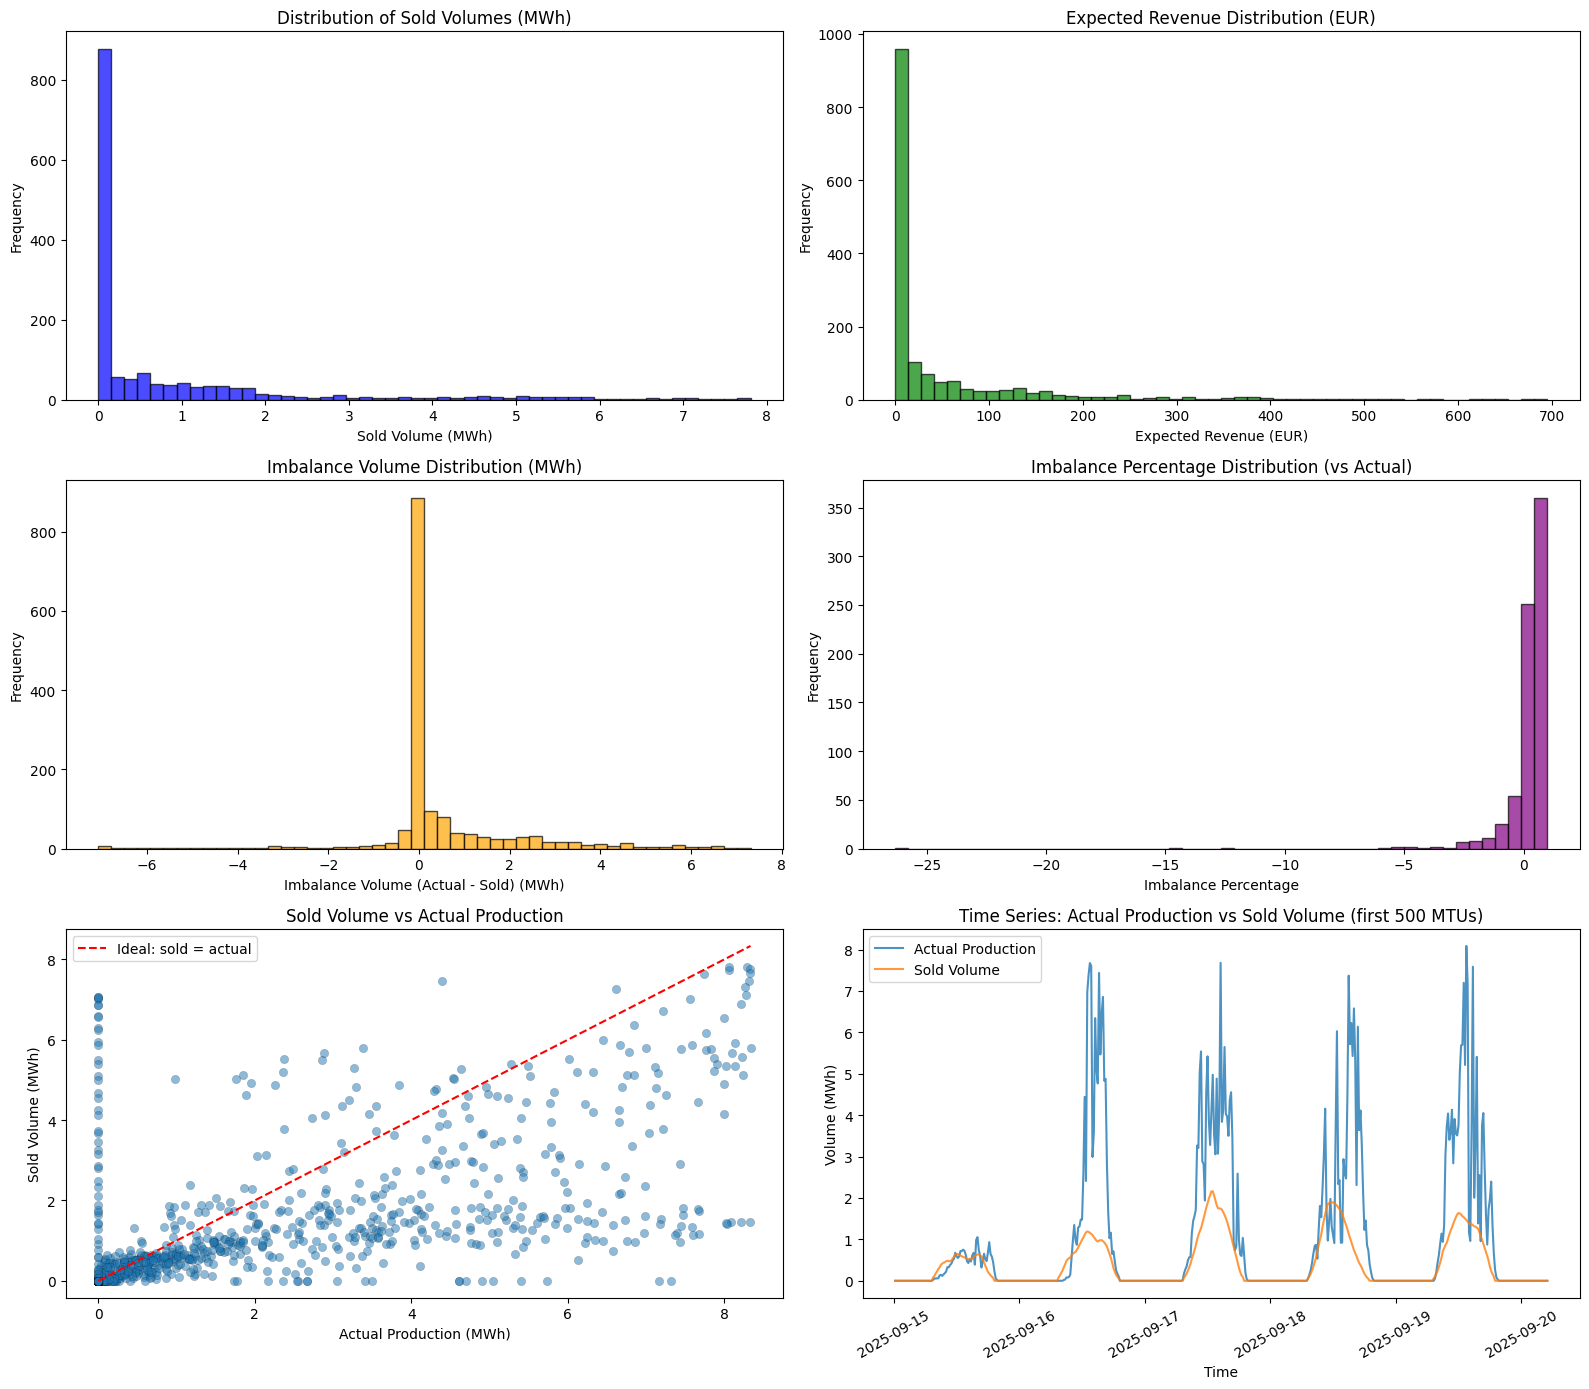

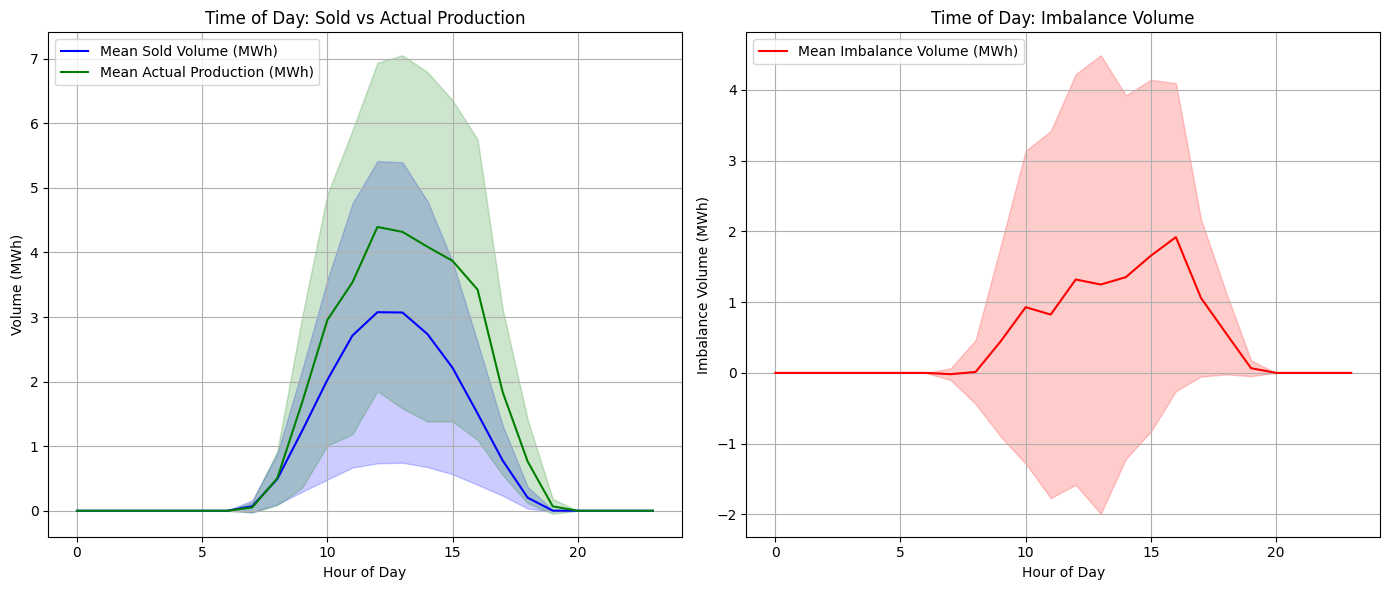

Revenue 75th percentile: 47.59 EUR
Revenue 95th percentile: 245.32 EUR
Revenue 99th percentile: 464.87 EUR
Number of MTUs above 95th percentile: 77
Number of MTUs above 99th percentile: 16


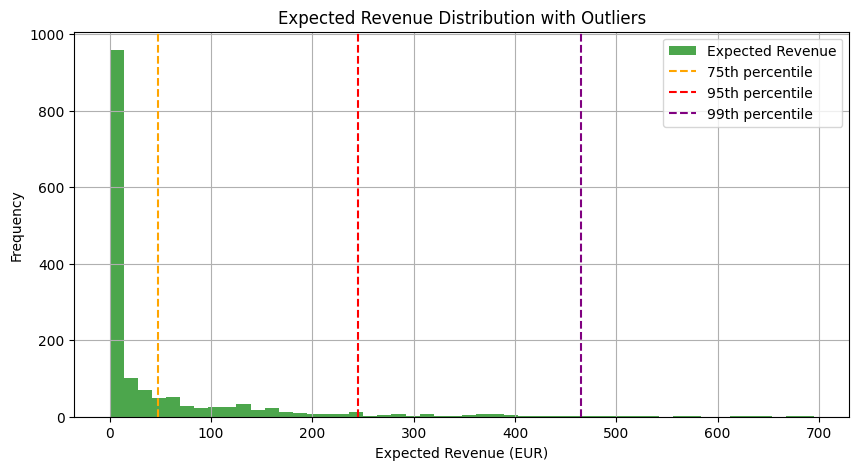


=== Outlier Revenue Summary ===
Mean revenue of 95th+ percentile MTUs: 393.51 EUR
Mean revenue of 99th+ percentile MTUs: 582.47 EUR

Top 10 Revenue Outlier MTUs:
              start_time  expected_revenue  sold_quantile  Actual_MWh  \
1489 2025-09-30 12:30:00        695.269880        7.07150         0.0   
1488 2025-09-30 12:15:00        695.269880        7.07150         0.0   
1490 2025-09-30 12:45:00        691.976160        7.03800         0.0   
1491 2025-09-30 13:00:00        675.556720        6.87100         0.0   
1487 2025-09-30 12:00:00        651.201915        7.01575         0.0   
1486 2025-09-30 11:45:00        636.721995        6.85975         0.0   
1485 2025-09-30 11:30:00        611.915850        6.59250         0.0   
1484 2025-09-30 11:15:00        584.023440        6.29200         0.0   
1492 2025-09-30 13:15:00        569.837782        6.57025         0.0   
1493 2025-09-30 13:30:00        540.869963        6.23625         0.0   

      imbalance_volume  
1489    

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
filename = "merged_predictions_with_quantile_strategy.xlsx"
df = pd.read_excel(filename)

print("Columns loaded:", df.columns.tolist())

# ----------------------------
# Calculate additional columns
# ----------------------------

# Imbalance volume: how far actual deviates from sold
df["imbalance_volume"] = df["Actual_MWh"] - df["sold_quantile"]

# Imbalance percentage (as % of actual or sold)
df["imbalance_pct"] = df["imbalance_volume"] / df["Actual_MWh"].replace(0, np.nan)

# Additional quantiles for deeper numerical insight
quantile_levels = [0.25, 0.5, 0.75]

def quantiles(series):
    return {f"{int(q*100)}th percentile": series.quantile(q) for q in quantile_levels}

# ----------------------------
# Core financial KPIs + extended stats
# ----------------------------
kpis = {
    "Total Expected Revenue (EUR)": df["expected_revenue"].sum(),
    "Total Objective Value (EUR)": df["objective_value"].sum(),
    "Mean Expected Revenue per MTU (EUR)": df["expected_revenue"].mean(),
    "Mean Objective Value per MTU (EUR)": df["objective_value"].mean(),

    # Sold vs production
    "Mean Sold Volume (MWh)": df["sold_quantile"].mean(),
    "Median Sold Volume (MWh)": df["sold_quantile"].median(),
    **quantiles(df["sold_quantile"]),
    "Mean Actual Production (MWh)": df["Actual_MWh"].mean(),
    "Median Actual Production (MWh)": df["Actual_MWh"].median(),
    **quantiles(df["Actual_MWh"]),

    # Volatility & imbalance
    "Std Dev of Sold Volume (MWh)": df["sold_quantile"].std(),
    "Std Dev of Actual Production (MWh)": df["Actual_MWh"].std(),
    "Mean Imbalance Volume (MWh)": df["imbalance_volume"].mean(),
    "Std Dev of Imbalance Volume (MWh)": df["imbalance_volume"].std(),
    **quantiles(df["imbalance_volume"]),
    "Mean Imbalance % (vs actual)": df["imbalance_pct"].mean(),

    # Operational insights
    "Zero Sales Frequency": (df["sold_quantile"] == 0).mean(),
    "Overcommitment Frequency (sold > actual)": (df["sold_quantile"] > df["Actual_MWh"]).mean(),
    "Undercommitment Frequency (sold < actual)": (df["sold_quantile"] < df["Actual_MWh"]).mean(),

    # Risk diagnostics
    "Min Objective Value": df["objective_value"].min(),
    "Number of MTUs with Negative Objective Value": (df["objective_value"] < 0).sum(),
    "Number of MTUs with Zero Objective Value": (df["objective_value"] == 0).sum(),

    # Revenue outliers
    "Max Expected Revenue": df["expected_revenue"].max(),
    "Min Expected Revenue": df["expected_revenue"].min(),
    "Std Dev of Expected Revenue": df["expected_revenue"].std(),
    "Revenue Skewness": df["expected_revenue"].skew(),
}

# ----------------------------
# Print KPIs
# ----------------------------
print("\n=== KPI Summary ===")
for k, v in kpis.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# ----------------------------
# Plots
# ----------------------------
plt.figure(figsize=(16, 14))

# Plot 1: Distribution of Sold Volumes
plt.subplot(3, 2, 1)
plt.hist(df["sold_quantile"], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Sold Volumes (MWh)")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")

# Plot 2: Expected Revenue Distribution
plt.subplot(3, 2, 2)
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Expected Revenue Distribution (EUR)")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")

# Plot 3: Imbalance Volume Distribution
plt.subplot(3, 2, 3)
plt.hist(df["imbalance_volume"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("Imbalance Volume Distribution (MWh)")
plt.xlabel("Imbalance Volume (Actual - Sold) (MWh)")
plt.ylabel("Frequency")

# Plot 4: Imbalance Percentage Distribution (excluding NaNs)
plt.subplot(3, 2, 4)
plt.hist(df["imbalance_pct"].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Imbalance Percentage Distribution (vs Actual)")
plt.xlabel("Imbalance Percentage")
plt.ylabel("Frequency")

# Plot 5: Sold vs Actual Production (scatter)
plt.subplot(3, 2, 5)
plt.scatter(df["Actual_MWh"], df["sold_quantile"], alpha=0.5, edgecolor='k', linewidths=0.2)
plt.plot([df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         [df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         'r--', label="Ideal: sold = actual")
plt.title("Sold Volume vs Actual Production")
plt.xlabel("Actual Production (MWh)")
plt.ylabel("Sold Volume (MWh)")
plt.legend()

# Plot 6: Time series of Sold vs Actual Production (first 500 points for visibility)
plt.subplot(3, 2, 6)
plt.plot(df["start_time"].iloc[:500], df["Actual_MWh"].iloc[:500], label="Actual Production", alpha=0.8)
plt.plot(df["start_time"].iloc[:500], df["sold_quantile"].iloc[:500], label="Sold Volume", alpha=0.8)
plt.title("Time Series: Actual Production vs Sold Volume (first 500 MTUs)")
plt.xlabel("Time")
plt.ylabel("Volume (MWh)")
plt.xticks(rotation=30)
plt.legend()

plt.tight_layout()
plt.show()


# Add hour of day for time series analysis
df["hour"] = df["start_time"].dt.hour

# Calculate imbalance volume and percentage
df["imbalance_volume"] = df["Actual_MWh"] - df["sold_quantile"]
df["imbalance_pct"] = df["imbalance_volume"] / df["Actual_MWh"].replace(0, np.nan)

# === Time of Day Profiles ===

# Aggregate mean values by hour
hourly_stats = df.groupby("hour").agg({
    "sold_quantile": ["mean", "std"],
    "Actual_MWh": ["mean", "std"],
    "imbalance_volume": ["mean", "std"]
})
hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_stats.index, hourly_stats["sold_quantile_mean"], label="Mean Sold Volume (MWh)", color='blue')
plt.fill_between(hourly_stats.index,
                 hourly_stats["sold_quantile_mean"] - hourly_stats["sold_quantile_std"],
                 hourly_stats["sold_quantile_mean"] + hourly_stats["sold_quantile_std"],
                 color='blue', alpha=0.2)

plt.plot(hourly_stats.index, hourly_stats["Actual_MWh_mean"], label="Mean Actual Production (MWh)", color='green')
plt.fill_between(hourly_stats.index,
                 hourly_stats["Actual_MWh_mean"] - hourly_stats["Actual_MWh_std"],
                 hourly_stats["Actual_MWh_mean"] + hourly_stats["Actual_MWh_std"],
                 color='green', alpha=0.2)

plt.title("Time of Day: Sold vs Actual Production")
plt.xlabel("Hour of Day")
plt.ylabel("Volume (MWh)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hourly_stats.index, hourly_stats["imbalance_volume_mean"], label="Mean Imbalance Volume (MWh)", color='red')
plt.fill_between(hourly_stats.index,
                 hourly_stats["imbalance_volume_mean"] - hourly_stats["imbalance_volume_std"],
                 hourly_stats["imbalance_volume_mean"] + hourly_stats["imbalance_volume_std"],
                 color='red', alpha=0.2)
plt.title("Time of Day: Imbalance Volume")
plt.xlabel("Hour of Day")
plt.ylabel("Imbalance Volume (MWh)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Revenue Outlier Analysis ===

# Define thresholds for outliers based on quantiles
revenue_q75 = df["expected_revenue"].quantile(0.75)
revenue_q95 = df["expected_revenue"].quantile(0.95)
revenue_q99 = df["expected_revenue"].quantile(0.99)

print(f"Revenue 75th percentile: {revenue_q75:.2f} EUR")
print(f"Revenue 95th percentile: {revenue_q95:.2f} EUR")
print(f"Revenue 99th percentile: {revenue_q99:.2f} EUR")

# Identify outlier MTUs
outliers_95 = df[df["expected_revenue"] >= revenue_q95]
outliers_99 = df[df["expected_revenue"] >= revenue_q99]

print(f"Number of MTUs above 95th percentile: {len(outliers_95)}")
print(f"Number of MTUs above 99th percentile: {len(outliers_99)}")

# Plot expected revenue distribution with outlier thresholds
plt.figure(figsize=(10, 5))
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', label="Expected Revenue")
plt.axvline(revenue_q75, color='orange', linestyle='--', label="75th percentile")
plt.axvline(revenue_q95, color='red', linestyle='--', label="95th percentile")
plt.axvline(revenue_q99, color='purple', linestyle='--', label="99th percentile")
plt.title("Expected Revenue Distribution with Outliers")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics of outliers
print("\n=== Outlier Revenue Summary ===")
print(f"Mean revenue of 95th+ percentile MTUs: {outliers_95['expected_revenue'].mean():.2f} EUR")
print(f"Mean revenue of 99th+ percentile MTUs: {outliers_99['expected_revenue'].mean():.2f} EUR")

# Optional: Inspect top outlier MTUs
top_outliers = outliers_99.sort_values("expected_revenue", ascending=False).head(10)
print("\nTop 10 Revenue Outlier MTUs:")
print(top_outliers[["start_time", "expected_revenue", "sold_quantile", "Actual_MWh", "imbalance_volume"]])

Columns loaded: ['start_time', 'P10_kW', 'P50_kW', 'P90_kW', 'Actual_kW', 'DA_price', 'P10_MWh', 'P50_MWh', 'P90_MWh', 'Actual_MWh', 'sold_quantile', 'expected_revenue', 'objective_value']
Detected quantile forecast columns: ['P10_kW', 'P50_kW', 'P90_kW']

=== Total Revenue per Quantile Forecast (with curtailment) ===
P10_kW: 98412.31 EUR
P50_kW: 87341.00 EUR
P90_kW: 52592.17 EUR

=== KPI Summary ===
Total Expected Revenue (EUR): 72218.3587
Total Objective Value (EUR): 72218.3587
Mean Expected Revenue per MTU (EUR): 47.0478
Mean Objective Value per MTU (EUR): 98.1228
Mean Sold Volume (MWh) - Curtailed: 0.6804
Median Sold Volume (MWh) - Curtailed: 0.0000
Mean Actual Production (MWh): 1.3134
Median Actual Production (MWh): 0.0000
Std Dev of Sold Volume (MWh) - Curtailed: 1.3343
Std Dev of Actual Production (MWh): 2.1794
Mean Imbalance Volume (MWh): 0.6330
Std Dev of Imbalance Volume (MWh): 1.3049
Mean Imbalance % (vs actual): 0.4459
Zero Sales Frequency: 0.5681
Overcommitment Frequency (

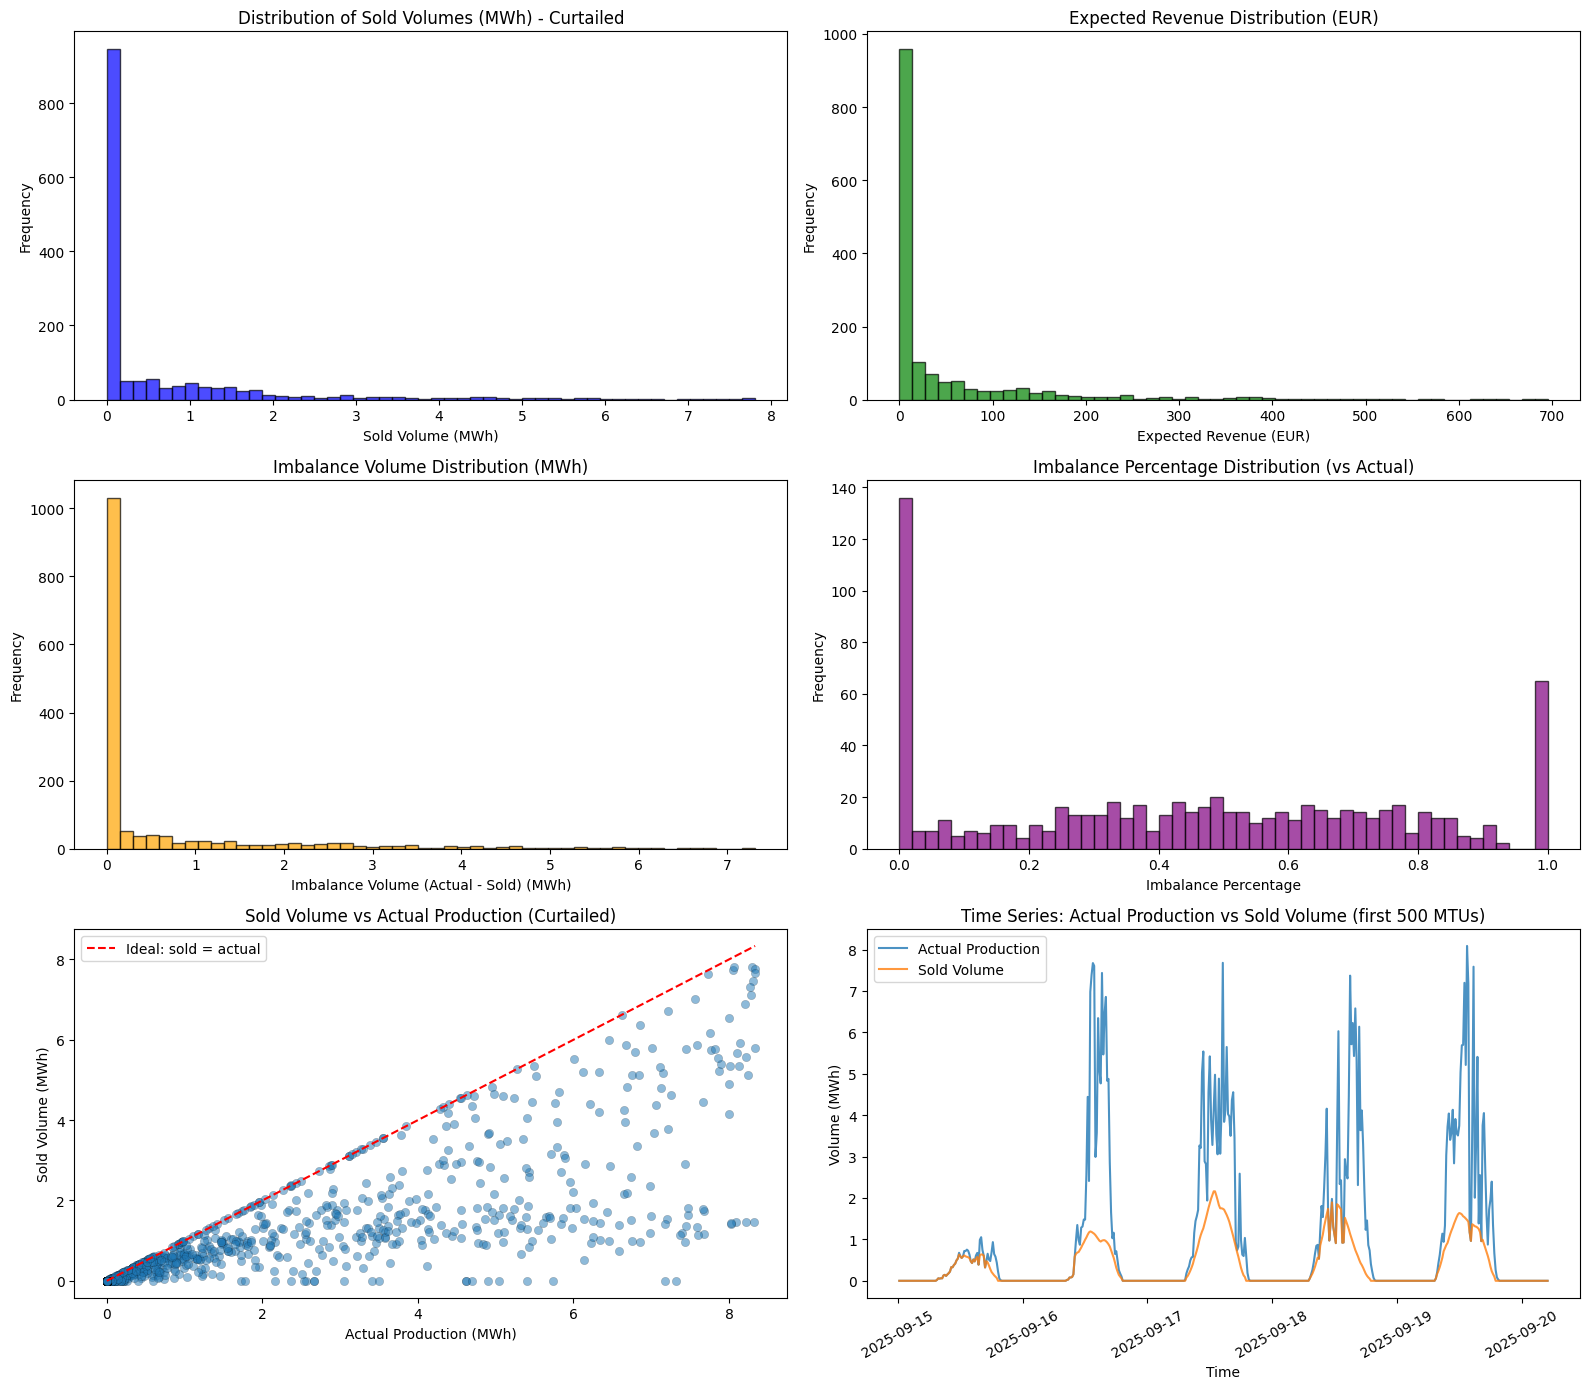

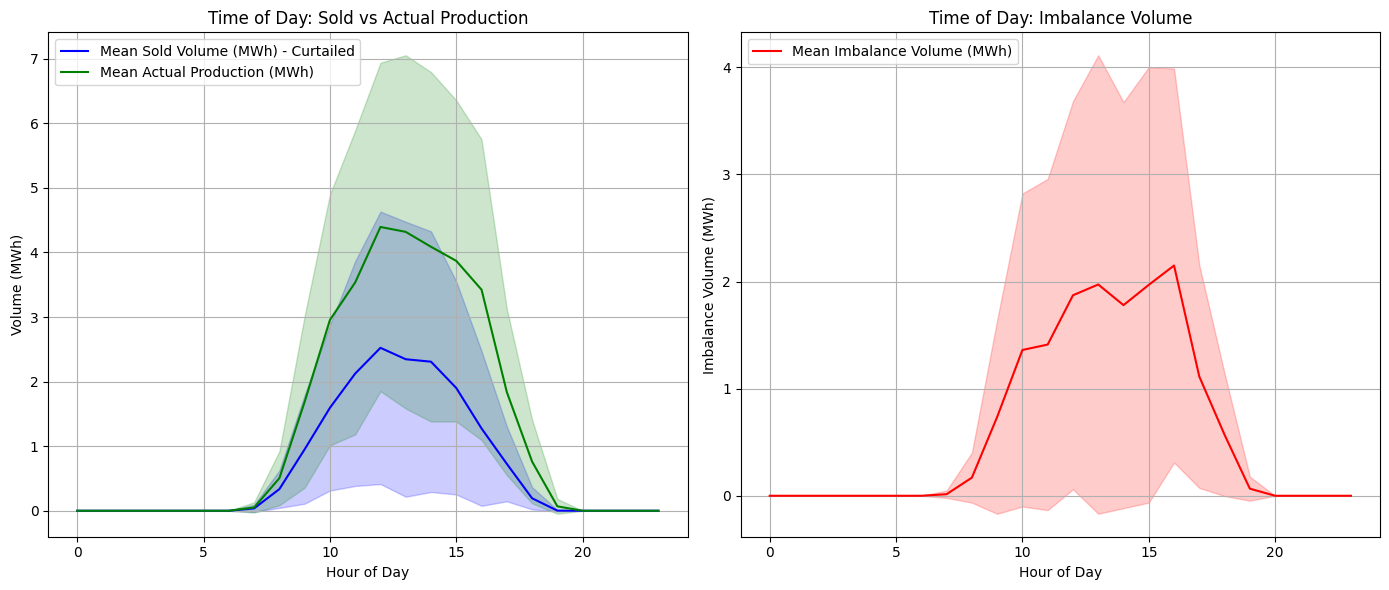

Revenue 75th percentile: 47.59 EUR
Revenue 95th percentile: 245.32 EUR
Revenue 99th percentile: 464.87 EUR
Number of MTUs above 95th percentile: 77
Number of MTUs above 99th percentile: 16


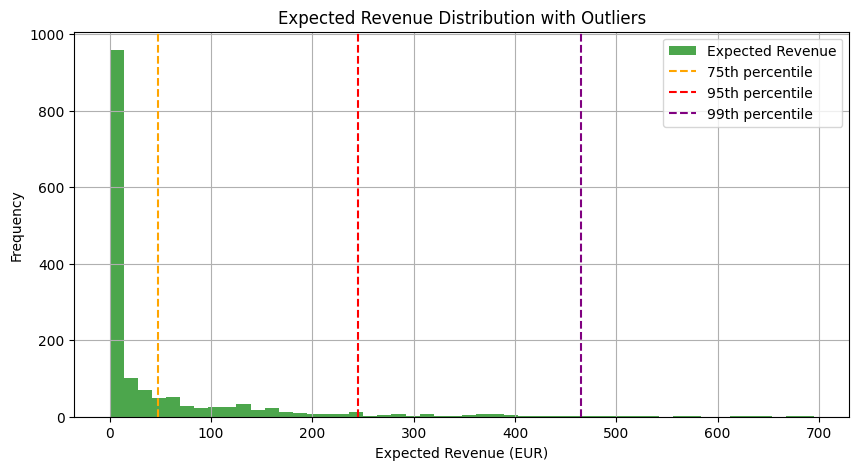


=== Outlier Revenue Summary ===
Mean revenue of 95th+ percentile MTUs: 393.51 EUR
Mean revenue of 99th+ percentile MTUs: 582.47 EUR

Top 10 Revenue Outlier MTUs:
              start_time  expected_revenue  sold_quantile  \
1489 2025-09-30 12:30:00        695.269880        7.07150   
1488 2025-09-30 12:15:00        695.269880        7.07150   
1490 2025-09-30 12:45:00        691.976160        7.03800   
1491 2025-09-30 13:00:00        675.556720        6.87100   
1487 2025-09-30 12:00:00        651.201915        7.01575   
1486 2025-09-30 11:45:00        636.721995        6.85975   
1485 2025-09-30 11:30:00        611.915850        6.59250   
1484 2025-09-30 11:15:00        584.023440        6.29200   
1492 2025-09-30 13:15:00        569.837782        6.57025   
1493 2025-09-30 13:30:00        540.869963        6.23625   

      sold_quantile_curtail  Actual_MWh  imbalance_volume  
1489                    0.0         0.0               0.0  
1488                    0.0         0.0      

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
filename = "merged_predictions_with_quantile_strategy.xlsx"
df = pd.read_excel(filename)

print("Columns loaded:", df.columns.tolist())

# Ensure datetime format for time series analysis
df["start_time"] = pd.to_datetime(df["start_time"])

# --- Enforce curtailment: sold volume cannot exceed actual production ---
df["sold_quantile_curtail"] = np.minimum(df["sold_quantile"], df["Actual_MWh"])

# Calculate imbalance volume based on curtailed sales
df["imbalance_volume"] = df["Actual_MWh"] - df["sold_quantile_curtail"]

# Imbalance percentage (relative to actual, safe division)
df["imbalance_pct"] = df["imbalance_volume"] / df["Actual_MWh"].replace(0, np.nan)

# --- Clarify imbalance revenue: Assuming upward price applies to positive imbalance, downward to negative ---

# For this, balancing prices need to be in df: assuming columns exist
if "balancing_upward_price" in df.columns and "balancing_downward_price" in df.columns:
    df["imbalance_revenue"] = np.where(
        df["imbalance_volume"] > 0,
        df["imbalance_volume"] * df["balancing_upward_price"],
        df["imbalance_volume"] * df["balancing_downward_price"]
    )
else:
    print("Warning: Balancing prices columns missing; imbalance revenue not calculated.")
    df["imbalance_revenue"] = np.nan

# --- Explicitly compare revenues by quantile forecast choice ---

# Extract quantile columns - adjust if your quantiles columns are named differently
quantile_cols = [col for col in df.columns if col.startswith("P") and col.endswith("_kW")]

print(f"Detected quantile forecast columns: {quantile_cols}")

# Calculate expected revenue per quantile forecast sold volume (enforcing curtailment per quantile)
revenue_per_quantile = {}
for col in quantile_cols:
    sold_col = col.replace("_kW", "_MWh")
    if sold_col not in df.columns:
        print(f"Warning: Expected sold volume column '{sold_col}' not found for quantile '{col}'. Skipping.")
        continue

    # Enforce curtailment for this quantile
    sold_curtail = np.minimum(df[sold_col], df["Actual_MWh"])

    # Assuming revenue = sold volume * DA price (or extend as needed)
    revenue = sold_curtail * df["DA_price"]

    revenue_per_quantile[col] = revenue.sum()

print("\n=== Total Revenue per Quantile Forecast (with curtailment) ===")
for quantile, rev in revenue_per_quantile.items():
    print(f"{quantile}: {rev:.2f} EUR")

# --- KPI calculation (existing but updated with curtailed sold volume) ---

kpis = {
    "Total Expected Revenue (EUR)": df["expected_revenue"].sum(),
    "Total Objective Value (EUR)": df["objective_value"].sum(),
    "Mean Expected Revenue per MTU (EUR)": df["expected_revenue"].mean(),
    "Mean Objective Value per MTU (EUR)": df["objective_value"].mean(),

    "Mean Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].mean(),
    "Median Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].median(),
    "Mean Actual Production (MWh)": df["Actual_MWh"].mean(),
    "Median Actual Production (MWh)": df["Actual_MWh"].median(),

    "Std Dev of Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].std(),
    "Std Dev of Actual Production (MWh)": df["Actual_MWh"].std(),
    "Mean Imbalance Volume (MWh)": df["imbalance_volume"].mean(),
    "Std Dev of Imbalance Volume (MWh)": df["imbalance_volume"].std(),
    "Mean Imbalance % (vs actual)": df["imbalance_pct"].mean(),

    "Zero Sales Frequency": (df["sold_quantile_curtail"] == 0).mean(),
    "Overcommitment Frequency (sold > actual)": (df["sold_quantile"] > df["Actual_MWh"]).mean(),  # original sold_quantile (uncurtailed)
    "Undercommitment Frequency (sold < actual)": (df["sold_quantile"] < df["Actual_MWh"]).mean(),

    "Min Objective Value": df["objective_value"].min(),
    "Number of MTUs with Negative Objective Value": (df["objective_value"] < 0).sum(),
    "Number of MTUs with Zero Objective Value": (df["objective_value"] == 0).sum(),

    "Max Expected Revenue": df["expected_revenue"].max(),
    "Min Expected Revenue": df["expected_revenue"].min(),
    "Std Dev of Expected Revenue": df["expected_revenue"].std(),
    "Revenue Skewness": df["expected_revenue"].skew(),
}

print("\n=== KPI Summary ===")
for k, v in kpis.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# --- Plotting ---

plt.figure(figsize=(16, 14))

plt.subplot(3, 2, 1)
plt.hist(df["sold_quantile_curtail"], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Sold Volumes (MWh) - Curtailed")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 2)
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Expected Revenue Distribution (EUR)")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 3)
plt.hist(df["imbalance_volume"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("Imbalance Volume Distribution (MWh)")
plt.xlabel("Imbalance Volume (Actual - Sold) (MWh)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 4)
plt.hist(df["imbalance_pct"].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Imbalance Percentage Distribution (vs Actual)")
plt.xlabel("Imbalance Percentage")
plt.ylabel("Frequency")

plt.subplot(3, 2, 5)
plt.scatter(df["Actual_MWh"], df["sold_quantile_curtail"], alpha=0.5, edgecolor='k', linewidths=0.2)
plt.plot([df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         [df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         'r--', label="Ideal: sold = actual")
plt.title("Sold Volume vs Actual Production (Curtailed)")
plt.xlabel("Actual Production (MWh)")
plt.ylabel("Sold Volume (MWh)")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(df["start_time"].iloc[:500], df["Actual_MWh"].iloc[:500], label="Actual Production", alpha=0.8)
plt.plot(df["start_time"].iloc[:500], df["sold_quantile_curtail"].iloc[:500], label="Sold Volume", alpha=0.8)
plt.title("Time Series: Actual Production vs Sold Volume (first 500 MTUs)")
plt.xlabel("Time")
plt.ylabel("Volume (MWh)")
plt.xticks(rotation=30)
plt.legend()

plt.tight_layout()
plt.show()

# --- Time of Day Profiles ---

df["hour"] = df["start_time"].dt.hour

hourly_stats = df.groupby("hour").agg({
    "sold_quantile_curtail": ["mean", "std"],
    "Actual_MWh": ["mean", "std"],
    "imbalance_volume": ["mean", "std"]
})
hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hourly_stats.index, hourly_stats["sold_quantile_curtail_mean"], label="Mean Sold Volume (MWh) - Curtailed", color='blue')
plt.fill_between(hourly_stats.index,
                 hourly_stats["sold_quantile_curtail_mean"] - hourly_stats["sold_quantile_curtail_std"],
                 hourly_stats["sold_quantile_curtail_mean"] + hourly_stats["sold_quantile_curtail_std"],
                 color='blue', alpha=0.2)

plt.plot(hourly_stats.index, hourly_stats["Actual_MWh_mean"], label="Mean Actual Production (MWh)", color='green')
plt.fill_between(hourly_stats.index,
                 hourly_stats["Actual_MWh_mean"] - hourly_stats["Actual_MWh_std"],
                 hourly_stats["Actual_MWh_mean"] + hourly_stats["Actual_MWh_std"],
                 color='green', alpha=0.2)

plt.title("Time of Day: Sold vs Actual Production")
plt.xlabel("Hour of Day")
plt.ylabel("Volume (MWh)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hourly_stats.index, hourly_stats["imbalance_volume_mean"], label="Mean Imbalance Volume (MWh)", color='red')
plt.fill_between(hourly_stats.index,
                 hourly_stats["imbalance_volume_mean"] - hourly_stats["imbalance_volume_std"],
                 hourly_stats["imbalance_volume_mean"] + hourly_stats["imbalance_volume_std"],
                 color='red', alpha=0.2)
plt.title("Time of Day: Imbalance Volume")
plt.xlabel("Hour of Day")
plt.ylabel("Imbalance Volume (MWh)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Revenue Outlier Analysis ---

revenue_q75 = df["expected_revenue"].quantile(0.75)
revenue_q95 = df["expected_revenue"].quantile(0.95)
revenue_q99 = df["expected_revenue"].quantile(0.99)

print(f"Revenue 75th percentile: {revenue_q75:.2f} EUR")
print(f"Revenue 95th percentile: {revenue_q95:.2f} EUR")
print(f"Revenue 99th percentile: {revenue_q99:.2f} EUR")

outliers_95 = df[df["expected_revenue"] >= revenue_q95]
outliers_99 = df[df["expected_revenue"] >= revenue_q99]

print(f"Number of MTUs above 95th percentile: {len(outliers_95)}")
print(f"Number of MTUs above 99th percentile: {len(outliers_99)}")

plt.figure(figsize=(10, 5))
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', label="Expected Revenue")
plt.axvline(revenue_q75, color='orange', linestyle='--', label="75th percentile")
plt.axvline(revenue_q95, color='red', linestyle='--', label="95th percentile")
plt.axvline(revenue_q99, color='purple', linestyle='--', label="99th percentile")
plt.title("Expected Revenue Distribution with Outliers")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Outlier Revenue Summary ===")
print(f"Mean revenue of 95th+ percentile MTUs: {outliers_95['expected_revenue'].mean():.2f} EUR")
print(f"Mean revenue of 99th+ percentile MTUs: {outliers_99['expected_revenue'].mean():.2f} EUR")

print("\nTop 10 Revenue Outlier MTUs:")
print(outliers_99[["start_time", "expected_revenue", "sold_quantile", "sold_quantile_curtail", "Actual_MWh", "imbalance_volume"]].sort_values("expected_revenue", ascending=False).head(10))


# FINAL MODIFICATION

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# =========================== #
# CONFIGURATION
# =========================== #
PREDICTIONS_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'
PREDICTIONS_SHEET = "Sheet1"

IMBALANCE_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx'
IMBALANCE_SHEET = "Worksheet"

OUTPUT_XLSX = "merged_predictions_with_quantile_strategy.xlsx"

NUM_SIMS = 3000
RNG_SEED = 2025
np.random.seed(RNG_SEED)

KW_TO_MWH = 0.25 / 1000.0  # 15 min interval in MWh
CURTAIL_ALLOWED = True
CURTAIL_COST_PER_MWH = 0.0

QUANTILE_LEVEL = 0.10  # lower quantile for more conservative strategy
USE_CVaR = True        # set False to use quantile instead

CVaR_ALPHA = 0.05

# Noise for imbalance simulation
ADD_IMBALANCE_NOISE = True
IMBALANCE_NOISE_PARAMS = {
    "sigma_up": 5.0,
    "sigma_down": 5.0,
    "spike_prob": 0.005,
    "spike_up_min": 100.0,
    "spike_up_max": 400.0
}

FALLBACK_UP_SPREAD = 30.0
FALLBACK_DOWN_SPREAD = 20.0

CANDIDATE_STEPS = 61
REFINE_RADIUS = 0.1
MIN_SOLD_THRESHOLD = 0.05

N_JOBS = -1


# =========================== #
# DATA LOADING
# =========================== #
def load_predictions(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")
    df = df.rename(columns={
        "pv_power_prediction_day_ahead_p10": "P10_kW",
        "pv_power_prediction_day_ahead_p50": "P50_kW",
        "pv_power_prediction_day_ahead_p90": "P90_kW",
        "actual_power": "Actual_kW",
        "day-ahead price": "DA_price"
    })
    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time").reset_index(drop=True)

    for col in ["P10_kW", "P50_kW", "P90_kW", "Actual_kW"]:
        df[f"{col.split('_')[0]}_MWh"] = df[col] * KW_TO_MWH

    return df


def load_imbalance_prices(path, sheet):
    data = pd.read_excel(path, sheet_name=sheet, header=2)
    cols = list(data.columns)
    from_idx = next((i for i, c in enumerate(cols) if str(c).strip().lower().startswith("from")), 0)
    est_cols = cols[from_idx:from_idx + 4]
    df = data[est_cols].copy()
    df.columns = ["start_time", "end_time", "upward_price", "downward_price"]
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["upward_price"] = pd.to_numeric(df["upward_price"], errors="coerce")
    df["downward_price"] = pd.to_numeric(df["downward_price"], errors="coerce")
    df = df.dropna(subset=["start_time"]).reset_index(drop=True)
    return df


# =========================== #
# SAMPLING FUNCTIONS
# =========================== #
def sample_production_tri(p10, p50, p90, n=NUM_SIMS):
    a, c, b = max(0.0, p10), max(0.0, p50), max(0.0, p90)
    if b <= a + 1e-12:
        return np.full(n, a)
    return np.random.triangular(a, c, b, size=n)


def sample_imbalance_prices(da_price, up_base, down_base, n=NUM_SIMS):
    if not ADD_IMBALANCE_NOISE or up_base is None:
        up_arr = np.full(n, da_price + FALLBACK_UP_SPREAD)
        down_arr = np.full(n, max(0.0, da_price - FALLBACK_DOWN_SPREAD))
        return up_arr, down_arr

    p = IMBALANCE_NOISE_PARAMS
    up_arr = up_base + np.random.normal(0, p["sigma_up"], n)
    down_arr = down_base + np.random.normal(0, p["sigma_down"], n)

    spike = np.random.rand(n) < p["spike_prob"]
    up_arr[spike] = np.random.uniform(p["spike_up_min"], p["spike_up_max"], spike.sum())

    return np.clip(up_arr, 0, None), np.clip(down_arr, 0, None)


# =========================== #
# REVENUE & OBJECTIVES (updated)
# =========================== #
def evaluate_revenue(sold, actual, da_price, up_arr, down_arr):
    da_rev = sold * da_price
    curtailed = np.maximum(0, actual - sold) if CURTAIL_ALLOWED else 0.0
    actual_used = np.minimum(actual, sold) if CURTAIL_ALLOWED else actual

    imbalance = actual_used - sold

    # Cap imbalance prices to avoid extreme spikes
    MAX_IMBALANCE_PRICE = 150.0  # EUR/MWh cap
    imbalance_prices = np.where(imbalance < 0, up_arr, down_arr)
    imbalance_prices = np.clip(imbalance_prices, 0, MAX_IMBALANCE_PRICE)

    imbalance_rev = imbalance * imbalance_prices
    curtail_cost = curtailed * CURTAIL_COST_PER_MWH

    return da_rev + imbalance_rev - curtail_cost


def compute_objective(revs):
    if USE_CVaR:
        sorted_revs = np.sort(revs)
        cutoff = int(len(sorted_revs) * CVaR_ALPHA)
        return np.mean(sorted_revs[:cutoff]) if cutoff > 0 else np.min(sorted_revs)
    else:
        return np.quantile(revs, QUANTILE_LEVEL)


# =========================== #
# MTU OPTIMIZATION (updated)
# =========================== #
def optimize_single_mtu(p10, p50, p90, da_price, up_base, down_base):
    actual_samples = sample_production_tri(p10, p50, p90)

    # Skip optimization if all samples near zero
    if np.all(actual_samples < 1e-4):
        return dict(sold=0.0, exp=0.0, obj=0.0)

    up_arr, down_arr = sample_imbalance_prices(da_price, up_base, down_base)

    mean_act = np.mean(actual_samples)
    std_act = np.std(actual_samples)
    upper = min(p90, mean_act + 1.0 * std_act)

    if upper < MIN_SOLD_THRESHOLD:
        return dict(sold=0.0, exp=0.0, obj=0.0)

    best = {"sold": 0.0, "obj": -np.inf, "exp": 0.0}
    for s in np.linspace(0, upper, CANDIDATE_STEPS):
        revs = evaluate_revenue(s, actual_samples, da_price, up_arr, down_arr)
        obj = compute_objective(revs)
        exp = np.mean(revs)
        if obj > best["obj"]:
            best = {"sold": s, "obj": obj, "exp": exp}

    # Clip sold volume so it does not exceed mean actual production
    best["sold"] = min(best["sold"], mean_act)

    if best["obj"] == -np.inf:
        best["obj"] = 0.0

    return best


# =========================== #
# FULL OPTIMIZATION LOOP
# =========================== #
def process_all_mtus(df_preds, df_imb):
    def process_row(row):
        time = row["start_time"]
        imb = df_imb[df_imb["start_time"] == time]
        up = imb["upward_price"].values[0] if not imb.empty else None
        down = imb["downward_price"].values[0] if not imb.empty else None

        res = optimize_single_mtu(
            row["P10_MWh"], row["P50_MWh"], row["P90_MWh"], row["DA_price"], up, down
        )
        return {
            "start_time": time,
            "sold_quantile": res["sold"],
            "expected_revenue": res["exp"],
            "objective_value": res["obj"]
        }

    results = Parallel(n_jobs=N_JOBS)(
        delayed(process_row)(row) for _, row in tqdm(df_preds.iterrows(), total=len(df_preds))
    )
    return pd.DataFrame(results)


# =========================== #
# MAIN
# =========================== #
def main():
    print("Loading data...")
    preds = load_predictions(PREDICTIONS_PATH, PREDICTIONS_SHEET)
    imb = load_imbalance_prices(IMBALANCE_PATH, IMBALANCE_SHEET)

    print("Optimizing MTUs...")
    results = process_all_mtus(preds, imb)

    final = pd.merge(preds, results, on="start_time", how="left")
    final.to_excel(OUTPUT_XLSX, index=False)
    print(f"Results saved to {OUTPUT_XLSX}")


if __name__ == "__main__":
    main()


Loading data...
Optimizing MTUs...


100%|██████████| 1535/1535 [00:05<00:00, 278.44it/s]


Results saved to merged_predictions_with_quantile_strategy.xlsx


Columns loaded: ['start_time', 'P10_kW', 'P50_kW', 'P90_kW', 'Actual_kW', 'DA_price', 'P10_MWh', 'P50_MWh', 'P90_MWh', 'Actual_MWh', 'sold_quantile', 'expected_revenue', 'objective_value']
Detected quantile forecast columns: ['P10_kW', 'P50_kW', 'P90_kW']

=== Total Revenue per Quantile Forecast (with curtailment) ===
P10: 98412.31 EUR
P50: 87341.00 EUR
P90: 52592.17 EUR

=== KPI Summary ===
Total Expected Revenue (EUR): 72218.3587
Total Objective Value (EUR): 72218.3587
Mean Expected Revenue per MTU (EUR): 47.0478
Mean Objective Value per MTU (EUR): 47.0478
Mean Sold Volume (MWh) - Curtailed: 0.6804
Median Sold Volume (MWh) - Curtailed: 0.0000
Mean Actual Production (MWh): 1.3134
Median Actual Production (MWh): 0.0000
Std Dev of Sold Volume (MWh) - Curtailed: 1.3343
Std Dev of Actual Production (MWh): 2.1794
Mean Imbalance Volume (MWh): 0.6330
Std Dev of Imbalance Volume (MWh): 1.3049
Mean Imbalance % (vs actual): 0.4459
Zero Sales Frequency: 0.5681
Overcommitment Frequency (sold > ac

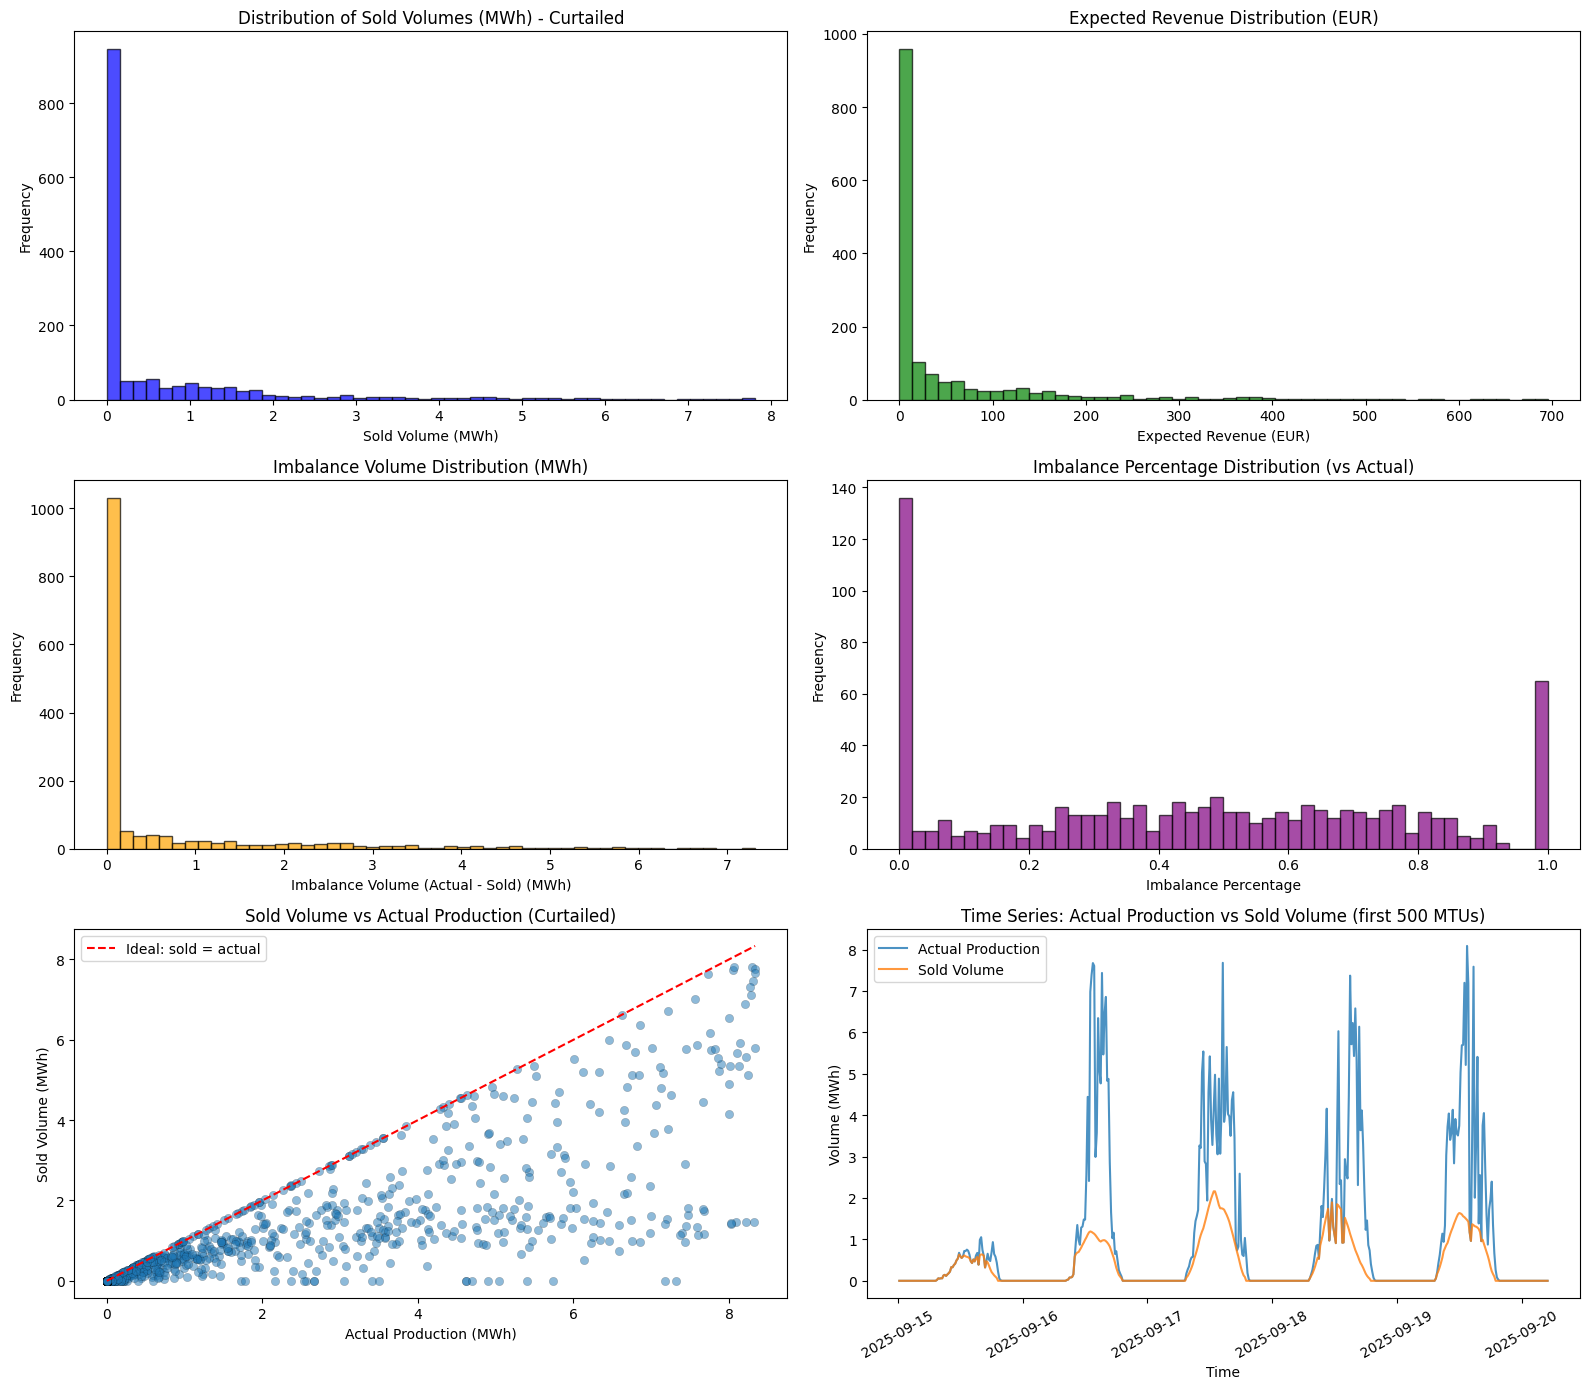

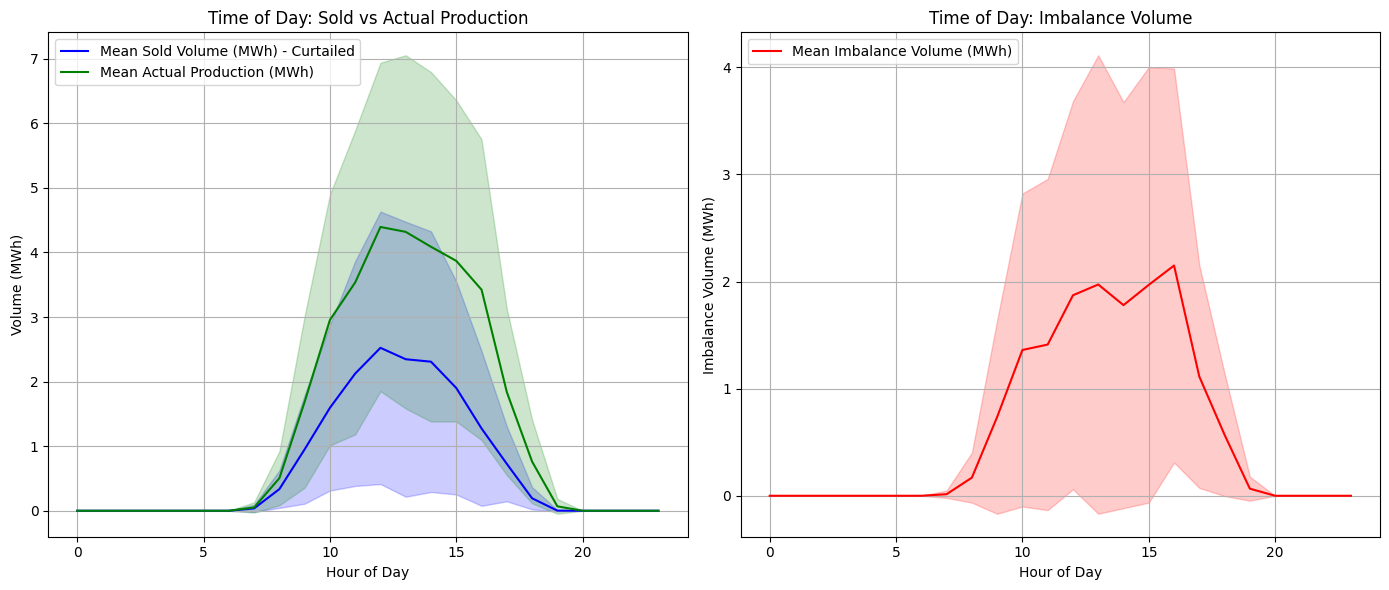

Revenue 75th percentile: 47.59 EUR
Revenue 95th percentile: 245.32 EUR
Revenue 99th percentile: 464.87 EUR
Number of MTUs above 95th percentile: 77
Number of MTUs above 99th percentile: 16


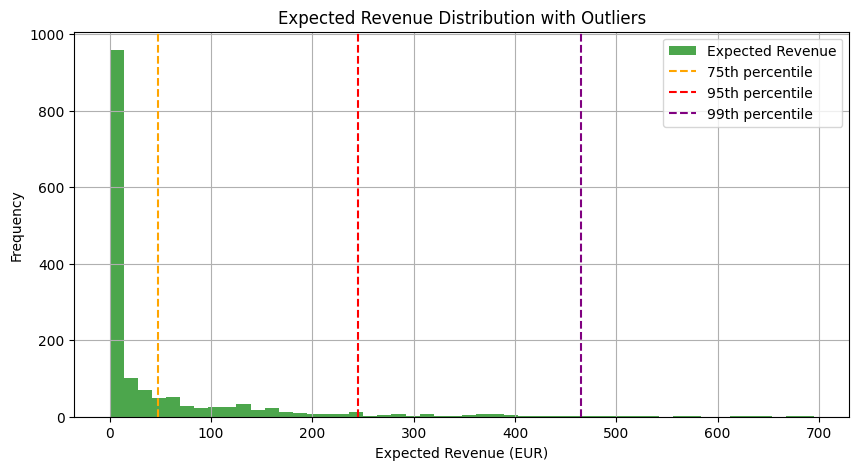


=== Outlier Revenue Summary ===
Mean revenue of 95th+ percentile MTUs: 393.51 EUR
Mean revenue of 99th+ percentile MTUs: 582.47 EUR

Top 10 Revenue Outlier MTUs:
              start_time  expected_revenue  sold_quantile  \
1489 2025-09-30 12:30:00        695.269880        7.07150   
1488 2025-09-30 12:15:00        695.269880        7.07150   
1490 2025-09-30 12:45:00        691.976160        7.03800   
1491 2025-09-30 13:00:00        675.556720        6.87100   
1487 2025-09-30 12:00:00        651.201915        7.01575   
1486 2025-09-30 11:45:00        636.721995        6.85975   
1485 2025-09-30 11:30:00        611.915850        6.59250   
1484 2025-09-30 11:15:00        584.023440        6.29200   
1492 2025-09-30 13:15:00        569.837782        6.57025   
1493 2025-09-30 13:30:00        540.869963        6.23625   

      sold_quantile_curtail  Actual_MWh  imbalance_volume  
1489                    0.0         0.0               0.0  
1488                    0.0         0.0      

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
filename = "merged_predictions_with_quantile_strategy.xlsx"
df = pd.read_excel(filename)

print("Columns loaded:", df.columns.tolist())

# Ensure datetime format for time series analysis
df["start_time"] = pd.to_datetime(df["start_time"])

# --- Enforce curtailment: sold volume cannot exceed actual production ---
df["sold_quantile_curtail"] = np.minimum(df["sold_quantile"], df["Actual_MWh"])

# Calculate imbalance volume based on curtailed sales
df["imbalance_volume"] = df["Actual_MWh"] - df["sold_quantile_curtail"]

# Imbalance percentage (relative to actual, safe division)
df["imbalance_pct"] = df["imbalance_volume"] / df["Actual_MWh"].replace(0, np.nan)

# --- Calculate imbalance revenue ---

# Assumes that df has columns for upward/downward prices from imbalance data, named as follows:
# If those columns do not exist, try to merge imbalance prices data here before proceeding.

imbalance_up_col = "upward_price"      # Adjust if named differently in your data
imbalance_down_col = "downward_price"  # Adjust if named differently in your data

if imbalance_up_col in df.columns and imbalance_down_col in df.columns:
    df["imbalance_revenue"] = np.where(
        df["imbalance_volume"] > 0,
        df["imbalance_volume"] * df[imbalance_up_col],
        df["imbalance_volume"] * df[imbalance_down_col]
    )
else:
    print("Warning: Imbalance price columns missing; imbalance revenue not calculated.")
    df["imbalance_revenue"] = np.nan

# --- Compare revenues for quantile forecasts ---

# Find quantile forecast columns for sold volumes and predictions
quantile_power_cols = [col for col in df.columns if col.startswith("P") and col.endswith("_kW")]
quantile_sold_cols = [col.replace("_kW", "_MWh") for col in quantile_power_cols]

print(f"Detected quantile forecast columns: {quantile_power_cols}")

revenue_per_quantile = {}
for sold_col in quantile_sold_cols:
    if sold_col not in df.columns:
        print(f"Warning: Sold volume column '{sold_col}' not found. Skipping.")
        continue

    # Enforce curtailment for that quantile
    sold_curtail = np.minimum(df[sold_col], df["Actual_MWh"])

    # Revenue assumed as sold volume * DA price (simplified)
    revenue = sold_curtail * df["DA_price"]

    quantile_name = sold_col.replace("_MWh", "")
    revenue_per_quantile[quantile_name] = revenue.sum()

print("\n=== Total Revenue per Quantile Forecast (with curtailment) ===")
for quantile, rev in revenue_per_quantile.items():
    print(f"{quantile}: {rev:.2f} EUR")

# --- KPI calculations (with curtailed sold volume) ---

kpis = {
    "Total Expected Revenue (EUR)": df["expected_revenue"].sum(),
    "Total Objective Value (EUR)": df["objective_value"].sum(),
    "Mean Expected Revenue per MTU (EUR)": df["expected_revenue"].mean(),
    "Mean Objective Value per MTU (EUR)": df["objective_value"].mean(),

    "Mean Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].mean(),
    "Median Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].median(),
    "Mean Actual Production (MWh)": df["Actual_MWh"].mean(),
    "Median Actual Production (MWh)": df["Actual_MWh"].median(),

    "Std Dev of Sold Volume (MWh) - Curtailed": df["sold_quantile_curtail"].std(),
    "Std Dev of Actual Production (MWh)": df["Actual_MWh"].std(),
    "Mean Imbalance Volume (MWh)": df["imbalance_volume"].mean(),
    "Std Dev of Imbalance Volume (MWh)": df["imbalance_volume"].std(),
    "Mean Imbalance % (vs actual)": df["imbalance_pct"].mean(),

    "Zero Sales Frequency": (df["sold_quantile_curtail"] == 0).mean(),
    "Overcommitment Frequency (sold > actual)": (df["sold_quantile"] > df["Actual_MWh"]).mean(),  # original uncurtailed
    "Undercommitment Frequency (sold < actual)": (df["sold_quantile"] < df["Actual_MWh"]).mean(),

    "Min Objective Value": df["objective_value"].min(),
    "Number of MTUs with Negative Objective Value": (df["objective_value"] < 0).sum(),
    "Number of MTUs with Zero Objective Value": (df["objective_value"] == 0).sum(),

    "Max Expected Revenue": df["expected_revenue"].max(),
    "Min Expected Revenue": df["expected_revenue"].min(),
    "Std Dev of Expected Revenue": df["expected_revenue"].std(),
    "Revenue Skewness": df["expected_revenue"].skew(),
}

print("\n=== KPI Summary ===")
for k, v in kpis.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# --- Plotting ---

plt.figure(figsize=(16, 14))

plt.subplot(3, 2, 1)
plt.hist(df["sold_quantile_curtail"], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution of Sold Volumes (MWh) - Curtailed")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 2)
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Expected Revenue Distribution (EUR)")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 3)
plt.hist(df["imbalance_volume"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("Imbalance Volume Distribution (MWh)")
plt.xlabel("Imbalance Volume (Actual - Sold) (MWh)")
plt.ylabel("Frequency")

plt.subplot(3, 2, 4)
plt.hist(df["imbalance_pct"].dropna(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Imbalance Percentage Distribution (vs Actual)")
plt.xlabel("Imbalance Percentage")
plt.ylabel("Frequency")

plt.subplot(3, 2, 5)
plt.scatter(df["Actual_MWh"], df["sold_quantile_curtail"], alpha=0.5, edgecolor='k', linewidths=0.2)
plt.plot([df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         [df["Actual_MWh"].min(), df["Actual_MWh"].max()],
         'r--', label="Ideal: sold = actual")
plt.title("Sold Volume vs Actual Production (Curtailed)")
plt.xlabel("Actual Production (MWh)")
plt.ylabel("Sold Volume (MWh)")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(df["start_time"].iloc[:500], df["Actual_MWh"].iloc[:500], label="Actual Production", alpha=0.8)
plt.plot(df["start_time"].iloc[:500], df["sold_quantile_curtail"].iloc[:500], label="Sold Volume", alpha=0.8)
plt.title("Time Series: Actual Production vs Sold Volume (first 500 MTUs)")
plt.xlabel("Time")
plt.ylabel("Volume (MWh)")
plt.xticks(rotation=30)
plt.legend()

plt.tight_layout()
plt.show()

# --- Time of Day Profiles ---

df["hour"] = df["start_time"].dt.hour

hourly_stats = df.groupby("hour").agg({
    "sold_quantile_curtail": ["mean", "std"],
    "Actual_MWh": ["mean", "std"],
    "imbalance_volume": ["mean", "std"]
})
hourly_stats.columns = ['_'.join(col).strip() for col in hourly_stats.columns.values]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hourly_stats.index, hourly_stats["sold_quantile_curtail_mean"], label="Mean Sold Volume (MWh) - Curtailed", color='blue')
plt.fill_between(hourly_stats.index,
                 hourly_stats["sold_quantile_curtail_mean"] - hourly_stats["sold_quantile_curtail_std"],
                 hourly_stats["sold_quantile_curtail_mean"] + hourly_stats["sold_quantile_curtail_std"],
                 color='blue', alpha=0.2)

plt.plot(hourly_stats.index, hourly_stats["Actual_MWh_mean"], label="Mean Actual Production (MWh)", color='green')
plt.fill_between(hourly_stats.index,
                 hourly_stats["Actual_MWh_mean"] - hourly_stats["Actual_MWh_std"],
                 hourly_stats["Actual_MWh_mean"] + hourly_stats["Actual_MWh_std"],
                 color='green', alpha=0.2)

plt.title("Time of Day: Sold vs Actual Production")
plt.xlabel("Hour of Day")
plt.ylabel("Volume (MWh)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hourly_stats.index, hourly_stats["imbalance_volume_mean"], label="Mean Imbalance Volume (MWh)", color='red')
plt.fill_between(hourly_stats.index,
                 hourly_stats["imbalance_volume_mean"] - hourly_stats["imbalance_volume_std"],
                 hourly_stats["imbalance_volume_mean"] + hourly_stats["imbalance_volume_std"],
                 color='red', alpha=0.2)
plt.title("Time of Day: Imbalance Volume")
plt.xlabel("Hour of Day")
plt.ylabel("Imbalance Volume (MWh)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Revenue Outlier Analysis ---

revenue_q75 = df["expected_revenue"].quantile(0.75)
revenue_q95 = df["expected_revenue"].quantile(0.95)
revenue_q99 = df["expected_revenue"].quantile(0.99)

print(f"Revenue 75th percentile: {revenue_q75:.2f} EUR")
print(f"Revenue 95th percentile: {revenue_q95:.2f} EUR")
print(f"Revenue 99th percentile: {revenue_q99:.2f} EUR")

outliers_95 = df[df["expected_revenue"] >= revenue_q95]
outliers_99 = df[df["expected_revenue"] >= revenue_q99]

print(f"Number of MTUs above 95th percentile: {len(outliers_95)}")
print(f"Number of MTUs above 99th percentile: {len(outliers_99)}")

plt.figure(figsize=(10, 5))
plt.hist(df["expected_revenue"], bins=50, alpha=0.7, color='green', label="Expected Revenue")
plt.axvline(revenue_q75, color='orange', linestyle='--', label="75th percentile")
plt.axvline(revenue_q95, color='red', linestyle='--', label="95th percentile")
plt.axvline(revenue_q99, color='purple', linestyle='--', label="99th percentile")
plt.title("Expected Revenue Distribution with Outliers")
plt.xlabel("Expected Revenue (EUR)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Outlier Revenue Summary ===")
print(f"Mean revenue of 95th+ percentile MTUs: {outliers_95['expected_revenue'].mean():.2f} EUR")
print(f"Mean revenue of 99th+ percentile MTUs: {outliers_99['expected_revenue'].mean():.2f} EUR")

print("\nTop 10 Revenue Outlier MTUs:")
print(outliers_99[["start_time", "expected_revenue", "sold_quantile", "sold_quantile_curtail", "Actual_MWh", "imbalance_volume"]].sort_values("expected_revenue", ascending=False).head(10))


In [ ]:
curtailment_applied = (df["sold_quantile_curtail"] < df["sold_quantile"]).sum()
print(f"Number of MTUs where curtailment capped sold volume: {curtailment_applied}")


Number of MTUs where curtailment capped sold volume: 187


Columns loaded: ['start_time', 'P10_kW', 'P50_kW', 'P90_kW', 'Actual_kW', 'DA_price', 'P10_MWh', 'P50_MWh', 'P90_MWh', 'Actual_MWh', 'sold_quantile', 'expected_revenue', 'objective_value']
Detected quantile forecast columns: ['P10_kW', 'P50_kW', 'P90_kW']

=== Total Revenue per Quantile Forecast (with curtailment) ===
P10_kW: 98412.31 EUR
P50_kW: 87341.00 EUR
P90_kW: 52592.17 EUR

Number of MTUs where curtailment capped sold volume: 187

=== KPI Comparison: Curtailment Capped vs Not Capped MTUs ===
Curtailment Capped - Total Expected Revenue (EUR)   26919.2077 |   45299.1510
Curtailment Capped - Total Objective Value (EUR)   26919.2077 |   45299.1510
Curtailment Capped - Mean Expected Revenue per MTU (EUR)     143.9530 |      33.6047
Curtailment Capped - Mean Objective Value per MTU (EUR)     143.9530 |      82.5121
Curtailment Capped - Mean Sold Volume (MWh) - Curtailed       0.8648 |       0.6548
Curtailment Capped - Median Sold Volume (MWh) - Curtailed       0.2117 |       0.0000
Cu

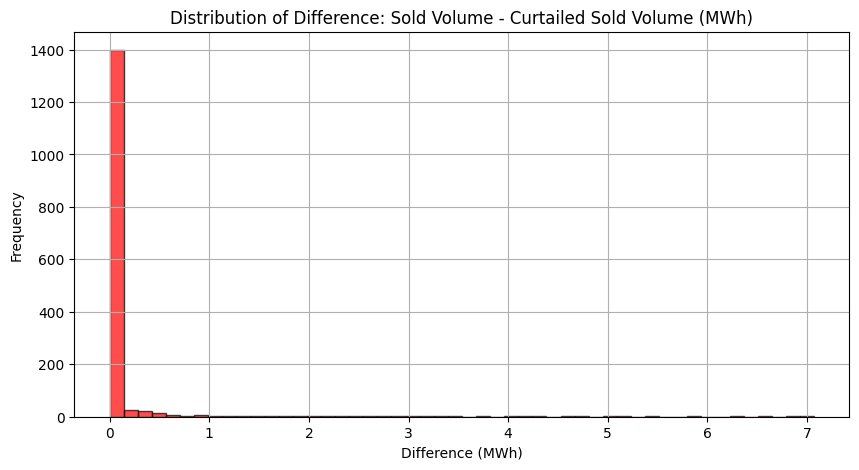

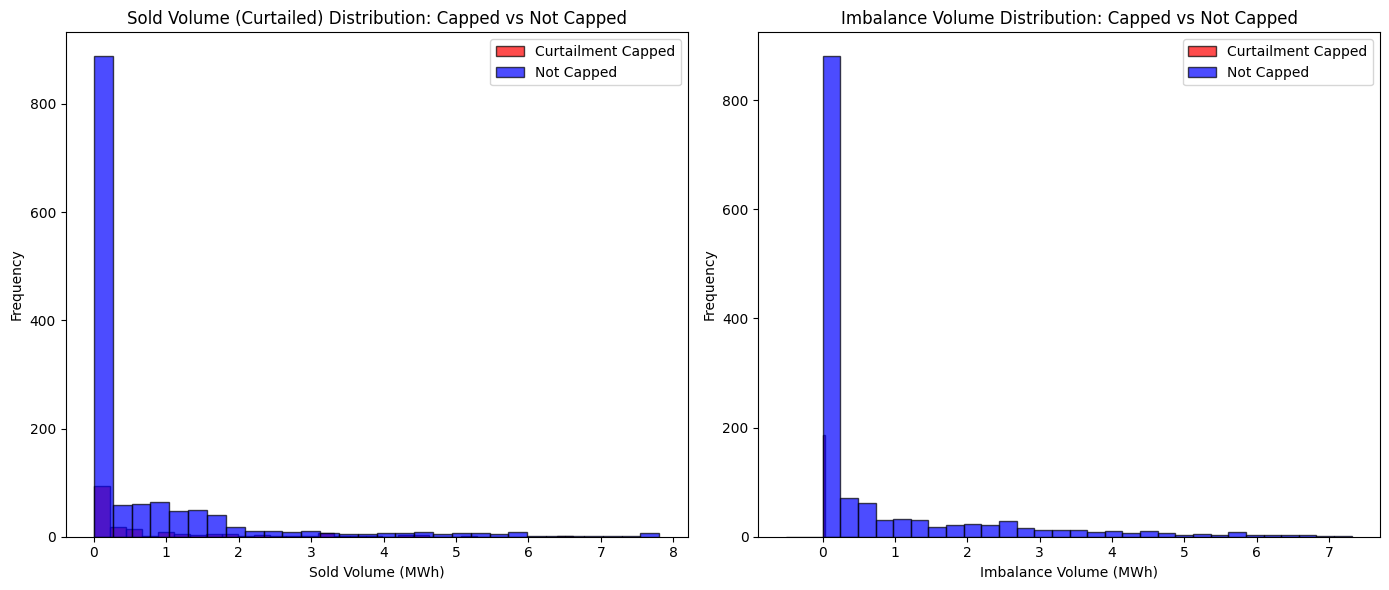

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load main dataset ---
filename = "merged_predictions_with_quantile_strategy.xlsx"
df = pd.read_excel(filename)
print("Columns loaded:", df.columns.tolist())

df["start_time"] = pd.to_datetime(df["start_time"])

# --- Load imbalance price data (Estonia) ---
imbalance_filename = "/content/drive/MyDrive/Colab Notebooks/Sunly test/balancing-energy-prices.2025-09-15-0015.2025-09-30-2345.eet.at2025-10-03-173023.xlsx"

# Skip first two rows which contain metadata/headers
imb_df = pd.read_excel(imbalance_filename, skiprows=2)

# Rename columns based on your example
imb_df.columns = [
    'From', 'To',
    'Estonia_Upward', 'Estonia_Downward',
    'Latvia_Upward', 'Latvia_Downward',
    'Lithuania_Upward', 'Lithuania_Downward'
]

# Convert to datetime for merging
imb_df['From'] = pd.to_datetime(imb_df['From'])
imb_df['To'] = pd.to_datetime(imb_df['To'])

# For merging, let's assume your MTU timestamps correspond to imbalance 'From'
# If not, adjust accordingly
df = df.merge(imb_df[['From', 'Estonia_Upward', 'Estonia_Downward']],
              left_on='start_time', right_on='From', how='left')

# Drop the redundant 'From' column after merge
df.drop(columns=['From'], inplace=True)

# Check if imbalance prices are loaded
if df[['Estonia_Upward', 'Estonia_Downward']].isnull().any().any():
    print("Warning: Some imbalance prices are missing after merge.")

# --- Enforce curtailment: sold volume cannot exceed actual production ---
df["sold_quantile_curtail"] = np.minimum(df["sold_quantile"], df["Actual_MWh"])

# Calculate imbalance volume based on curtailed sales
df["imbalance_volume"] = df["Actual_MWh"] - df["sold_quantile_curtail"]

# Imbalance percentage (relative to actual, safe division)
df["imbalance_pct"] = df["imbalance_volume"] / df["Actual_MWh"].replace(0, np.nan)

# --- Calculate imbalance revenue using Estonia imbalance prices ---
df["imbalance_revenue"] = np.where(
    df["imbalance_volume"] > 0,
    df["imbalance_volume"] * df["Estonia_Upward"],
    df["imbalance_volume"] * df["Estonia_Downward"]
)

# Replace NaNs with 0 or appropriate value if prices missing
df["imbalance_revenue"] = df["imbalance_revenue"].fillna(0)

# --- Total Revenue per Quantile Forecast (with curtailment) ---
quantile_cols = [col for col in df.columns if col.startswith("P") and col.endswith("_kW")]
print(f"Detected quantile forecast columns: {quantile_cols}")

revenue_per_quantile = {}
for col in quantile_cols:
    sold_col = col.replace("_kW", "_MWh")
    if sold_col not in df.columns:
        print(f"Warning: Expected sold volume column '{sold_col}' not found for quantile '{col}'. Skipping.")
        continue

    sold_curtail = np.minimum(df[sold_col], df["Actual_MWh"])
    revenue = sold_curtail * df["DA_price"]
    revenue_per_quantile[col] = revenue.sum()

print("\n=== Total Revenue per Quantile Forecast (with curtailment) ===")
for quantile, rev in revenue_per_quantile.items():
    print(f"{quantile}: {rev:.2f} EUR")

# --- KPI summary function ---
def calc_kpis(data, prefix=""):
    return {
        f"{prefix} Total Expected Revenue (EUR)": data["expected_revenue"].sum(),
        f"{prefix} Total Objective Value (EUR)": data["objective_value"].sum(),
        f"{prefix} Mean Expected Revenue per MTU (EUR)": data["expected_revenue"].mean(),
        f"{prefix} Mean Objective Value per MTU (EUR)": data["objective_value"].mean(),
        f"{prefix} Mean Sold Volume (MWh) - Curtailed": data["sold_quantile_curtail"].mean(),
        f"{prefix} Median Sold Volume (MWh) - Curtailed": data["sold_quantile_curtail"].median(),
        f"{prefix} Mean Actual Production (MWh)": data["Actual_MWh"].mean(),
        f"{prefix} Median Actual Production (MWh)": data["Actual_MWh"].median(),
        f"{prefix} Std Dev of Sold Volume (MWh) - Curtailed": data["sold_quantile_curtail"].std(),
        f"{prefix} Std Dev of Actual Production (MWh)": data["Actual_MWh"].std(),
        f"{prefix} Mean Imbalance Volume (MWh)": data["imbalance_volume"].mean(),
        f"{prefix} Std Dev of Imbalance Volume (MWh)": data["imbalance_volume"].std(),
        f"{prefix} Mean Imbalance % (vs actual)": data["imbalance_pct"].mean(),
        f"{prefix} Zero Sales Frequency": (data["sold_quantile_curtail"] == 0).mean(),
        f"{prefix} Overcommitment Frequency (sold > actual)": (data["sold_quantile"] > data["Actual_MWh"]).mean(),
        f"{prefix} Undercommitment Frequency (sold < actual)": (data["sold_quantile"] < data["Actual_MWh"]).mean(),
        f"{prefix} Min Objective Value": data["objective_value"].min(),
        f"{prefix} Number of MTUs with Negative Objective Value": (data["objective_value"] < 0).sum(),
        f"{prefix} Number of MTUs with Zero Objective Value": (data["objective_value"] == 0).sum(),
        f"{prefix} Max Expected Revenue": data["expected_revenue"].max(),
        f"{prefix} Min Expected Revenue": data["expected_revenue"].min(),
        f"{prefix} Std Dev of Expected Revenue": data["expected_revenue"].std(),
        f"{prefix} Revenue Skewness": data["expected_revenue"].skew(),
    }

# --- Identify MTUs where curtailment capped sold volume ---
df["curtailment_capped"] = df["sold_quantile_curtail"] < df["sold_quantile"]

num_capped = df["curtailment_capped"].sum()
print(f"\nNumber of MTUs where curtailment capped sold volume: {num_capped}")

# Split dataset
df_capped = df[df["curtailment_capped"]]
df_not_capped = df[~df["curtailment_capped"]]

# Calculate KPIs for both groups
kpis_capped = calc_kpis(df_capped, prefix="Curtailment Capped -")
kpis_not_capped = calc_kpis(df_not_capped, prefix="Not Capped -")

# Print KPI comparison
print("\n=== KPI Comparison: Curtailment Capped vs Not Capped MTUs ===")
for k in kpis_capped.keys():
    val_capped = kpis_capped[k]
    val_not_capped = kpis_not_capped.get(k.replace("Curtailment Capped -", "Not Capped -"), np.nan)
    if isinstance(val_capped, float):
        print(f"{k:40} {val_capped:12.4f} | {val_not_capped:12.4f}")
    else:
        print(f"{k:40} {val_capped:12} | {val_not_capped}")

# --- Distribution analysis of difference between sold and curtailed sold volumes ---
df["sold_minus_curtail"] = df["sold_quantile"] - df["sold_quantile_curtail"]

print(f"\nStats on difference between sold and curtailed sold volumes:")
print(df["sold_minus_curtail"].describe())

# Plot histogram of difference
plt.figure(figsize=(10, 5))
plt.hist(df["sold_minus_curtail"], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title("Distribution of Difference: Sold Volume - Curtailed Sold Volume (MWh)")
plt.xlabel("Difference (MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# --- Plot distributions for KPI-related columns for capped vs not capped ---

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_capped["sold_quantile_curtail"], bins=30, alpha=0.7, label="Curtailment Capped", color='red', edgecolor='black')
plt.hist(df_not_capped["sold_quantile_curtail"], bins=30, alpha=0.7, label="Not Capped", color='blue', edgecolor='black')
plt.title("Sold Volume (Curtailed) Distribution: Capped vs Not Capped")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_capped["imbalance_volume"], bins=30, alpha=0.7, label="Curtailment Capped", color='red', edgecolor='black')
plt.hist(df_not_capped["imbalance_volume"], bins=30, alpha=0.7, label="Not Capped", color='blue', edgecolor='black')
plt.title("Imbalance Volume Distribution: Capped vs Not Capped")
plt.xlabel("Imbalance Volume (MWh)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()
